# Thesis Benchmark Analysis — Playground

**Research questions:**

| RQ | Question | Primary metric |
|----|----------|----------------|
| **RQ1** | Does LLM function-naming accuracy degrade with compiler optimization level? | Paired Token F1 decay (O0 → O3) |
| **RQ2** | Does ground-truth confidence tier confound the results? | Per-tier Token F1 with Kruskal-Wallis |
| **RQ3** | Does a top-3 shortlist improve over the top-1 prediction? | Top-k uplift (F1_topk − F1_top1) |

**Design:**
- Ground truth joined **post-hoc** — LLM never sees GT names (leak-proof by construction)
- Cross-optimization pairing via **stable key** = `test_case|decl_file|decl_line|decl_column|name_norm`
- Token F1 = set-based harmonic mean of token precision & recall (SymLM/DIRTY convention)

**Conventions:**
- Positive delta = degradation (baseline was better)
- BRONZE tier has no O0 baseline → baseline is O1 when computing decay
- All CIs are 95% bootstrap (10 000 resamples)
- All p-values corrected via Holm-Bonferroni where multiple comparisons exist

## §0 — Setup, Imports & Configuration

In [1]:
# ── Imports ──────────────────────────────────────────────────────────────────
from __future__ import annotations

import json
import sys
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Ensure reforge package is importable
REFORGE_ROOT = Path.cwd().resolve().parent
if str(REFORGE_ROOT) not in sys.path:
    sys.path.insert(0, str(REFORGE_ROOT))

from data.experiments import THESIS_MODELS
from data.loader import load_dataset, load_ghidra_dataset
from data.metrics import (
    compute_reason_shift,
    compute_transitions,
    compute_verdict_rates,
    enrich_pairs,
)

# ── Plotting defaults ────────────────────────────────────────────────────────
sns.set_theme(style="whitegrid", context="paper", font_scale=1.15)
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "font.family": "serif",
})
warnings.filterwarnings("ignore", category=FutureWarning)

# ── Constants ────────────────────────────────────────────────────────────────
API = "http://localhost:8080"
FIGURES = REFORGE_ROOT / "figures" / "benchmark_v2"
FIGURES.mkdir(parents=True, exist_ok=True)
(FIGURES / "tables").mkdir(exist_ok=True)

OPT_ORDER = ["O0", "O1", "O2", "O3"]
TIER_ORDER = ["GOLD", "SILVER", "BRONZE"]

# BRONZE has no O0 data → baseline is O1 for decay computation
TIER_BASELINE: Dict[str, str] = {
    "GOLD": "O0",
    "SILVER": "O0",
    "BRONZE": "O1",
}

# Model display names (source of truth: data/experiments.py THESIS_MODELS)
MODEL_LABELS: Dict[str, str] = {v: k for k, v in THESIS_MODELS.items()}
# Add human-readable aliases
_PRETTY = {
    "gpt4o-mini":      "GPT-4o mini",
    "deepseek-v3":     "DeepSeek V3",
    "claude-sonnet45":  "Claude Sonnet 4.5",
    "llama31-70b":      "Llama-3.1 70B",
    "deepseek-r1":      "DeepSeek R1",
    "qwen3-coder":      "Qwen3 Coder",
    "gpt51":            "GPT-5.1",
}
MODEL_LABELS = {k: _PRETTY.get(v, v) for k, v in MODEL_LABELS.items()}

# Colour palette for models (colour-blind safe)
MODEL_PALETTE = dict(zip(MODEL_LABELS.values(), sns.color_palette("colorblind", len(MODEL_LABELS))))

# Tier colours (distinguishable on white/grey backgrounds)
TIER_COLORS = {"GOLD": "#D4AF37", "SILVER": "#808080", "BRONZE": "#A0522D"}

# Number of bootstrap resamples for CIs
N_BOOT = 10_000

# ── Helpers ──────────────────────────────────────────────────────────────────
import urllib.request

def api_get(path: str):
    """GET from the local Reforge API, return parsed JSON."""
    url = f"{API}{path}"
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req, timeout=30) as resp:
        return json.loads(resp.read().decode())


def bootstrap_ci(data, statistic=np.mean, n_boot=N_BOOT, ci=0.95):
    """Return (lower, upper) bootstrap percentile CI for *statistic*."""
    data = np.asarray(data)
    data = data[~np.isnan(data)]
    if len(data) < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(42)
    boot = np.array([statistic(rng.choice(data, size=len(data), replace=True))
                     for _ in range(n_boot)])
    alpha = (1 - ci) / 2
    return (np.percentile(boot, 100 * alpha), np.percentile(boot, 100 * (1 - alpha)))


def rank_biserial(x, y):
    """Rank-biserial correlation (effect size for Wilcoxon signed-rank)."""
    d = np.asarray(x) - np.asarray(y)
    d = d[d != 0]
    n = len(d)
    if n == 0:
        return 0.0
    ranks = stats.rankdata(np.abs(d))
    r_plus = np.sum(ranks[d > 0])
    r_minus = np.sum(ranks[d < 0])
    return (r_plus - r_minus) / (r_plus + r_minus)


def savefig(fig, name, **kw):
    """Save figure as PDF + PNG to the thesis figures directory."""
    for ext in ("pdf", "png"):
        fig.savefig(FIGURES / f"{name}.{ext}", **kw)
    print(f"  → saved {name}.{{pdf,png}}")


print(f"REFORGE_ROOT: {REFORGE_ROOT}")
print(f"FIGURES:      {FIGURES}")
print(f"Models:       {len(MODEL_LABELS)}")
for model_id, label in MODEL_LABELS.items():
    print(f"  {label:25s} ← {model_id}")

REFORGE_ROOT: C:\Users\nico_\Documents\UNI\Thesis\Source\reforge
FIGURES:      C:\Users\nico_\Documents\UNI\Thesis\Source\reforge\figures\benchmark_v2
Models:       7
  GPT-4o mini               ← openai/gpt-4o-mini
  DeepSeek V3               ← deepseek/deepseek-chat-v3-0324
  Claude Sonnet 4.5         ← anthropic/claude-sonnet-4.5
  Llama-3.1 70B             ← meta-llama/llama-3.1-70b-instruct
  DeepSeek R1               ← deepseek/deepseek-r1-0528
  Qwen3 Coder               ← qwen/qwen3-coder
  GPT-5.1                   ← openai/gpt-5.1


## §1 — Data Loading

Two data sources:
1. **LLM benchmark results** — scored predictions from the Reforge API (`df`)
2. **Pipeline (compiler-side) data** — oracle/alignment artefacts from local files (`ds`, `gds`)

In [2]:
# ── §1a: Load LLM benchmark results from API ────────────────────────────────

# Check API health
try:
    health = api_get("/health")
    print(f"API status: {health.get('status', 'unknown')}")
except Exception as exc:
    raise RuntimeError(f"API not reachable at {API}: {exc}") from exc

# Fetch experiment list
all_exps = api_get("/data/experiments")
benchmark_exps = [
    e for e in all_exps
    if "benchmark-v2" in e.get("tags", [])
    and e.get("status") != "LEGACY"
]
print(f"Benchmark experiments: {len(benchmark_exps)}")

# Load scored results into a flat list of dicts
rows: list[dict] = []
for e in benchmark_exps:
    exp_id = e["id"]
    model = e.get("model", "")
    tier = e.get("tier", "")
    opt = e.get("opt", "")
    ctx = e.get("context_level", "")
    top_k = e.get("top_k", 1)

    try:
        resp = api_get(f"/results/{exp_id}/scores")
        scored = resp.get("rows", resp) if isinstance(resp, dict) else resp
    except Exception:
        print(f"  ⚠ {exp_id}: no scored results")
        continue

    for r in scored:
        meta = r.get("metadata", {})
        rows.append({
            # Identity
            "experiment_id":       exp_id,
            "model":               model,
            "model_label":         MODEL_LABELS.get(model, model),
            "tier":                tier,
            "opt":                 opt,
            "context_level":       ctx,
            "dwarf_function_id":   r.get("dwarf_function_id", ""),
            "test_case":           r.get("test_case", ""),
            # Predictions
            "predicted_name":      r.get("predicted_name", ""),
            "ground_truth":        r.get("ground_truth_name", ""),
            # Scores (from scoring.py ScoredRow)
            "token_f1":            r.get("token_f1"),
            "exact_match":         r.get("exact_match_norm"),       # API field = exact_match_norm
            "is_trivial":          r.get("is_trivial_prediction"),  # from scorer, not reimplemented
            # Top-k
            "token_f1_topk":       r.get("token_f1_topk"),
            "exact_match_topk":    r.get("exact_match_topk"),
            "best_candidate_index": r.get("best_candidate_index"),
            "topk_uplift":         r.get("topk_uplift"),
            # Parse status
            "parse_ok":            r.get("parse_ok", meta.get("parse_ok")),
            # Stable key & quality proxies
            "stable_key":          meta.get("stable_key", ""),
            "confidence_tier":     meta.get("confidence_tier", ""),
            "quality_weight":      meta.get("quality_weight"),
            "overlap_ratio":       meta.get("overlap_ratio"),
            "bb_count":            meta.get("bb_count"),
            "cyclomatic":          meta.get("cyclomatic"),
            "loc_decompiled":      meta.get("loc_decompiled"),
            "top_k":               top_k,
        })

df = pd.DataFrame(rows)
print(f"\nLoaded {len(df)} scored rows across {df['experiment_id'].nunique()} experiments")
print(f"Models:  {sorted(df['model_label'].unique())}")
print(f"Tiers:   {sorted(df['tier'].unique())}")
print(f"Opts:    {sorted(df['opt'].unique())}")

API status: healthy
Benchmark experiments: 84
  ⚠ bench_gpt4o-mini_bronze_O0_L2_topk3: no scored results
  ⚠ bench_deepseek-v3_bronze_O0_L2_topk3: no scored results
  ⚠ bench_gpt51_bronze_O0_L2_topk3: no scored results
  ⚠ bench_claude-sonnet45_bronze_O0_L2_topk3: no scored results
  ⚠ bench_llama31-70b_bronze_O0_L2_topk3: no scored results
  ⚠ bench_deepseek-r1_bronze_O0_L2_topk3: no scored results
  ⚠ bench_qwen3-coder_bronze_O0_L2_topk3: no scored results

Loaded 4837 scored rows across 77 experiments
Models:  ['Claude Sonnet 4.5', 'DeepSeek R1', 'DeepSeek V3', 'GPT-4o mini', 'GPT-5.1', 'Llama-3.1 70B', 'Qwen3 Coder']
Tiers:   ['BRONZE', 'GOLD', 'SILVER']
Opts:    ['O0', 'O1', 'O2', 'O3']


In [3]:
# ── §1b: Schema validation gate ──────────────────────────────────────────────
# Fail fast if expected columns are missing — prevents silent NaN propagation.

REQUIRED_COLUMNS = [
    "model", "model_label", "opt", "tier", "test_case",
    "stable_key", "confidence_tier",
    "token_f1", "exact_match", "is_trivial",
    "token_f1_topk", "exact_match_topk", "topk_uplift", "best_candidate_index",
    "parse_ok",
    "overlap_ratio", "quality_weight",
    "bb_count", "cyclomatic", "loc_decompiled",
    "predicted_name", "ground_truth",
]

missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
assert not missing, f"Missing columns in df: {missing}"

# ── Boolean coercion (prevents bitwise-NOT bug: ~1 = -2) ────────────────────
df["parse_ok"] = df["parse_ok"].fillna(True).astype(bool)
df["exact_match"] = df["exact_match"].fillna(False).astype(bool)
df["is_trivial"] = df["is_trivial"].fillna(False).astype(bool)

# Validate — no negative ints lingering
assert df["parse_ok"].dtype == bool, f"parse_ok dtype: {df['parse_ok'].dtype}"
assert df["exact_match"].dtype == bool
assert (~df["parse_ok"]).sum() >= 0, "parse_ok bitwise NOT produced negatives"

print("Schema validation: ✓")
print(f"  Columns:  {len(df.columns)}")
print(f"  Rows:     {len(df)}")
print(f"  parse_ok: {df['parse_ok'].value_counts().to_dict()}")
print(f"  exact_match: {df['exact_match'].value_counts().to_dict()}")
print(f"\nColumn dtypes:")
print(df[REQUIRED_COLUMNS].dtypes.to_string())

Schema validation: ✓
  Columns:  26
  Rows:     4837
  parse_ok: {True: 4835, False: 2}
  exact_match: {False: 4642, True: 195}

Column dtypes:
model                       str
model_label                 str
opt                         str
tier                        str
test_case                   str
stable_key                  str
confidence_tier             str
token_f1                float64
exact_match                bool
is_trivial                 bool
token_f1_topk           float64
exact_match_topk           bool
topk_uplift             float64
best_candidate_index      int64
parse_ok                   bool
overlap_ratio            object
quality_weight          float64
bb_count                 object
cyclomatic               object
loc_decompiled          float64
predicted_name              str
ground_truth                str


In [4]:
# ── §1c: Load pipeline (compiler-side) data ──────────────────────────────────
# Oracle/alignment results — independent of any LLM. Shows how optimization
# degrades ground-truth quality before any predictions are made.

ds = load_dataset(opt_levels=["O0", "O1", "O2", "O3"])
df_pairs = enrich_pairs(ds.pairs)
df_report = compute_verdict_rates(ds.reports)

# Ghidra-join dataset (for yield/funnel/decompiler quality)
gds = load_ghidra_dataset(opt_levels=["O0", "O1", "O2", "O3"])

# Cross-opt transitions (O0→O3)
df_trans_o0o3 = compute_transitions(df_pairs, ds.non_targets, "O0", "O3")
df_trans_o0o1 = compute_transitions(df_pairs, ds.non_targets, "O0", "O1")

print(f"\nPipeline data loaded:")
print(f"  Pairs:          {len(df_pairs)} rows across {df_pairs['test_case'].nunique()} test cases")
print(f"  Reports:        {len(df_report)} rows")
print(f"  Transitions:    O0→O3 = {len(df_trans_o0o3)}, O0→O1 = {len(df_trans_o0o1)}")
print(f"  Ghidra funcs:   {len(gds.functions)}")
print(f"  Ghidra reports: {len(gds.reports)}")


Pipeline data loaded:
  Pairs:          702 rows across 15 test cases
  Reports:        60 rows
  Transitions:    O0→O3 = 414, O0→O1 = 391
  Ghidra funcs:   1792
  Ghidra reports: 60


## §2 — Data Quality & Cohort Checks

Before any claims, we establish:
1. **Completeness**: grid of (model × tier × opt) counts — any empty cells?
2. **Cohort stability**: how many functions are trackable across all opt levels via stable keys?
3. **Attrition funnel**: where do functions get lost in the pipeline?
4. **BRONZE/O0 handling**: explicit flagging of empty cells

In [5]:
# ── §2a: Completeness grid ────────────────────────────────────────────────────
pivot_counts = df.pivot_table(
    index=["model_label", "tier"],
    columns="opt",
    values="token_f1",
    aggfunc="count",
).reindex(columns=OPT_ORDER)

print("Function counts per (model, tier, opt):")
display(pivot_counts.fillna(0).astype(int))

# ── Flag empty cells ─────────────────────────────────────────────────────────
empty_cells = []
for model_label in df["model_label"].unique():
    for tier in TIER_ORDER:
        for opt in OPT_ORDER:
            n = len(df[(df["model_label"] == model_label) & (df["tier"] == tier) & (df["opt"] == opt)])
            if n == 0:
                empty_cells.append((model_label, tier, opt))
                print(f"  ⚠ EMPTY: {model_label} / {tier} / {opt}")

if not empty_cells:
    print("  No empty cells.")
else:
    print(f"\n  {len(empty_cells)} empty cell(s) — these will be excluded from decay computations.")

# ── NaN audit ────────────────────────────────────────────────────────────────
for col in ["token_f1", "exact_match", "parse_ok", "stable_key"]:
    n_nan = df[col].isna().sum() if col != "stable_key" else (df[col] == "").sum()
    print(f"  NaN/empty {col}: {n_nan}/{len(df)}")

Function counts per (model, tier, opt):


opt                        O0   O1  O2  O3
model_label       tier                    
Claude Sonnet 4.5 BRONZE    0   17  30  33
                  GOLD    196  121  92  85
                  SILVER   29   23  32  34
DeepSeek R1       BRONZE    0   17  30  33
                  GOLD    196  119  88  84
                  SILVER   29   23  32  34
DeepSeek V3       BRONZE    0   17  30  33
                  GOLD    196  121  92  85
                  SILVER   29   23  32  34
GPT-4o mini       BRONZE    0   17  30  33
                  GOLD    196  121  92  85
                  SILVER   29   23  32  34
GPT-5.1           BRONZE    0   17  30  33
                  GOLD    196  121  92  85
                  SILVER   29   23  32  34
Llama-3.1 70B     BRONZE    0   17  30  33
                  GOLD    196  121  92  85
                  SILVER   29   23  32  34
Qwen3 Coder       BRONZE    0   17  30  33
                  GOLD    196  121  92  85
                  SILVER   29   23  32  34

  ⚠ EMPTY: GPT-4o mini / BRONZE / O0
  ⚠ EMPTY: DeepSeek V3 / BRONZE / O0
  ⚠ EMPTY: GPT-5.1 / BRONZE / O0
  ⚠ EMPTY: Claude Sonnet 4.5 / BRONZE / O0
  ⚠ EMPTY: Llama-3.1 70B / BRONZE / O0
  ⚠ EMPTY: DeepSeek R1 / BRONZE / O0
  ⚠ EMPTY: Qwen3 Coder / BRONZE / O0

  7 empty cell(s) — these will be excluded from decay computations.
  NaN/empty token_f1: 0/4837
  NaN/empty exact_match: 0/4837
  NaN/empty parse_ok: 0/4837
  NaN/empty stable_key: 0/4837


In [29]:
# ── §2b: Cohort stability ─────────────────────────────────────────────────────
# For paired analysis we need functions (stable_key) present at all opt levels.
# BRONZE has no O0 → we compute two cohorts: O0-O3 (full) and O1-O3 (BRONZE-safe).

cohort_rows = []
for model_label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == model_label]
    for tier in TIER_ORDER:
        tdf = mdf[mdf["tier"] == tier]
        # Only consider non-null, non-sentinel stable keys
        tdf_keyed = tdf[tdf["stable_key"].notna() & (tdf["stable_key"].str.len() > 0)]
        tdf_keyed = tdf_keyed[~tdf_keyed["stable_key"].str.startswith("_unstable")]

        total_keys = tdf_keyed["stable_key"].nunique()

        # Full cohort (O0-O3): keys present at all 4 levels
        keys_by_opt = {
            opt: set(tdf_keyed.loc[tdf_keyed["opt"] == opt, "stable_key"])
            for opt in OPT_ORDER
        }
        full_cohort = set.intersection(*keys_by_opt.values()) if all(keys_by_opt.values()) else set()

        # Bronze-safe cohort (O1-O3): keys present at O1, O2, O3
        o1o3_opts = ["O1", "O2", "O3"]
        keys_o1o3 = {
            opt: set(tdf_keyed.loc[tdf_keyed["opt"] == opt, "stable_key"])
            for opt in o1o3_opts
        }
        o1o3_cohort = set.intersection(*keys_o1o3.values()) if all(keys_o1o3.values()) else set()

        full_cov = len(full_cohort) / max(total_keys, 1)
        o1o3_cov = len(o1o3_cohort) / max(total_keys, 1)

        cohort_rows.append({
            "model":          model_label,
            "tier":           tier,
            "total_keys":     total_keys,
            "full_cohort":    len(full_cohort),
            "o1o3_cohort":    len(o1o3_cohort),
            "full_coverage":  full_cov,
            "o1o3_coverage":  o1o3_cov,
            "full_cov_str":   f"{full_cov*100:.0f}%",
            "o1o3_cov_str":   f"{o1o3_cov*100:.0f}%",
        })

df_cohort = pd.DataFrame(cohort_rows)
print("Cohort coverage table (stable-key intersection across opt levels):")
display(df_cohort)

# ── Tier-hopping diagnostic ───────────────────────────────────────────────────
# §5b builds paired cohorts CROSS-TIER (ignoring tier column).
# This diagnostic shows how many functions hop between tiers across opt levels.
print("\n── Tier-hopping diagnostic ──")
keyed = df[df["stable_key"].notna() & (df["stable_key"].str.len() > 0)]
keyed = keyed[~keyed["stable_key"].str.startswith("_unstable")]
tier_per_key = keyed.groupby("stable_key")["tier"].nunique()
multi_tier = tier_per_key[tier_per_key > 1]
print(f"Unique stable keys: {len(tier_per_key)}")
print(f"Keys appearing in >1 tier: {len(multi_tier)} / {len(tier_per_key)}  ({len(multi_tier)/len(tier_per_key)*100:.1f}%)")
print("These tier-hopping keys ARE included in §5b paired analysis (cross-tier design).")
print("This is valid because token_f1 is scored against the same ground_truth_name regardless of tier;"
      "\ntier only reflects DWARF-alignment confidence, not a different ground truth.")

Cohort coverage table (stable-key intersection across opt levels):


,model,tier,total_keys,full_cohort,o1o3_cohort,full_coverage,o1o3_coverage,full_cov_str,o1o3_cov_str
0,Claude Sonnet 4.5,GOLD,199,82,83,0.412060,0.417085,41%,42%
1,Claude Sonnet 4.5,SILVER,60,0,18,0.000000,0.300000,0%,30%
2,Claude Sonnet 4.5,BRONZE,18,0,11,0.000000,0.611111,0%,61%
3,DeepSeek R1,GOLD,199,77,78,0.386935,0.391960,39%,39%
4,DeepSeek R1,SILVER,60,0,18,0.000000,0.300000,0%,30%
5,DeepSeek R1,BRONZE,18,0,11,0.000000,0.611111,0%,61%
6,DeepSeek V3,GOLD,200,81,82,0.405000,0.410000,40%,41%
7,DeepSeek V3,SILVER,60,0,18,0.000000,0.300000,0%,30%
8,DeepSeek V3,BRONZE,18,0,11,0.000000,0.611111,0%,61%
9,GPT-4o mini,GOLD,199,82,83,0.412060,0.417085,41%,42%



── Tier-hopping diagnostic ──
Unique stable keys: 220
Keys appearing in >1 tier: 58 / 220  (26.4%)
These tier-hopping keys ARE included in §5b paired analysis (cross-tier design).
This is valid because token_f1 is scored against the same ground_truth_name regardless of tier;
tier only reflects DWARF-alignment confidence, not a different ground truth.


In [31]:
# ── §2c: Attrition funnel (pipeline yield per opt) ───────────────────────────
# From the Ghidra-join reports: how many functions survive each quality gate?
# NOTE: "Oracle ACCEPT" gate removed — tautological (gold eligibility requires it).

funnel_cols = [
    ("excl_n_eligible_for_gold", "Eligible for Gold"),
    # ("funnel_n_pass_oracle_accept", ...),  # tautological — always == eligible
    ("funnel_n_pass_align_match", "Align MATCH"),
    ("funnel_n_pass_align_unique", "Unique candidate"),
    ("funnel_n_pass_align_ratio", "Ratio ≥ 0.95"),
    ("funnel_n_pass_joined_strong", "JOINED_STRONG"),
    ("funnel_n_pass_not_noise", "Not noise"),
    ("funnel_n_pass_cfg_not_low", "CFG not LOW"),
    ("funnel_n_pass_no_fatal_warnings", "No fatal warnings"),
    ("funnel_n_high_confidence", "High confidence"),
]

# Aggregate across test cases per opt level
# Each row in gds.reports is one (test_case, opt) = one binary — no overlap.
funnel_data = []
for opt in OPT_ORDER:
    rpt = gds.reports[gds.reports["opt"] == opt]
    if rpt.empty:
        continue
    row = {"opt": opt}
    for col, label in funnel_cols:
        if col in rpt.columns:
            row[label] = rpt[col].sum()
        else:
            row[label] = np.nan
    funnel_data.append(row)

df_funnel = pd.DataFrame(funnel_data).set_index("opt")
print("Pipeline attrition funnel (aggregate across test cases):")
display(df_funnel.T)

# Yield ratios — decompose where the loss happens
print("\nYield ratios (derived):")
yield_rows = []
for opt in df_funnel.index:
    elig = df_funnel.loc[opt, "Eligible for Gold"]
    match = df_funnel.loc[opt, "Align MATCH"]
    hc = df_funnel.loc[opt, "High confidence"]
    yield_rows.append({
        "opt": opt,
        "HC / Eligible":  f"{hc/max(elig,1)*100:.1f}%",
        "HC / MATCH":     f"{hc/max(match,1)*100:.1f}%",
        "MATCH / Eligible": f"{match/max(elig,1)*100:.1f}%",
    })
print(pd.DataFrame(yield_rows).set_index("opt").to_string())

# Flag non-binding gates (identical to their predecessor at every opt)
prev_label = funnel_cols[0][1]
non_binding = []
for _, label in funnel_cols[1:]:
    if (df_funnel[label] == df_funnel[prev_label]).all():
        non_binding.append(label)
    prev_label = label
if non_binding:
    print(f"\nNon-binding gates in this corpus (identical to predecessor at all opts): {non_binding}")
    print("These gates DO NOT filter any additional functions here, but may matter in larger corpora.")

# Verdict rates summary
# NOTE: rates are macro-averaged (each test case weighted equally).
# To weight by function count instead, use a weighted mean.
print("\nAlignment verdict rates (%) per opt [macro-average over test cases]:")
rate_cols = ["opt", "match_rate", "ambiguous_rate", "no_match_rate", "non_target_rate"]
display(
    df_report.groupby("opt")[["match_rate", "ambiguous_rate", "no_match_rate", "non_target_rate"]]
    .mean()
    .reindex(OPT_ORDER)
    .round(1)
)

Pipeline attrition funnel (aggregate across test cases):


opt,O0,O1,O2,O3
Eligible for Gold,226,163,134,129
Align MATCH,197,153,116,111
Unique candidate,197,141,103,96
Ratio ≥ 0.95,197,140,102,95
JOINED_STRONG,197,121,92,85
Not noise,197,121,92,85
CFG not LOW,197,121,92,85
No fatal warnings,197,121,92,85
High confidence,197,121,92,85



Yield ratios (derived):
    HC / Eligible HC / MATCH MATCH / Eligible
opt                                          
O0          87.2%     100.0%            87.2%
O1          74.2%      79.1%            93.9%
O2          68.7%      79.3%            86.6%
O3          65.9%      76.6%            86.0%

Non-binding gates in this corpus (identical to predecessor at all opts): ['Not noise', 'CFG not LOW', 'No fatal warnings', 'High confidence']
These gates DO NOT filter any additional functions here, but may matter in larger corpora.

Alignment verdict rates (%) per opt [macro-average over test cases]:


,match_rate,ambiguous_rate,no_match_rate,non_target_rate
opt,,,,
O0,46.9,8.1,0.0,44.9
O1,32.6,0.0,3.5,63.9
O2,27.2,0.3,4.8,67.8
O3,26.2,0.5,4.9,68.5


## §3 — Overall Model Ranking (Figure 1)

Aggregate Token F1 and Exact Match across all tiers and opt levels.
This gives a **global overview** before drilling into RQ1–RQ3.

Model ranking (all tiers × all opts):


,Model,n,F1 mean,F1 [95% CI],F1 median,% non-zero,EM%,F1-topk mean,F1-topk [95% CI],Uplift mean
0,Claude Sonnet 4.5,692,0.291598,"[0.267, 0.317]",0.000000,49.710983,7.080925,0.407129,"[0.381, 0.434]",0.115531
4,GPT-5.1,692,0.265782,"[0.245, 0.287]",0.285714,54.190751,2.745665,0.345383,"[0.324, 0.367]",0.079600
1,DeepSeek R1,685,0.263916,"[0.240, 0.288]",0.000000,48.321168,5.985401,0.357829,"[0.332, 0.383]",0.093913
6,Qwen3 Coder,692,0.246229,"[0.223, 0.270]",0.000000,44.219653,4.479769,0.308767,"[0.285, 0.333]",0.062538
2,DeepSeek V3,692,0.226989,"[0.206, 0.248]",0.000000,44.942197,1.878613,0.300991,"[0.277, 0.325]",0.074002
5,Llama-3.1 70B,692,0.221780,"[0.200, 0.244]",0.000000,41.907514,3.034682,0.297137,"[0.275, 0.320]",0.075358
3,GPT-4o mini,692,0.177312,"[0.158, 0.197]",0.000000,35.838150,3.034682,0.233505,"[0.212, 0.256]",0.056193


  → saved fig01_model_ranking.{pdf,png}


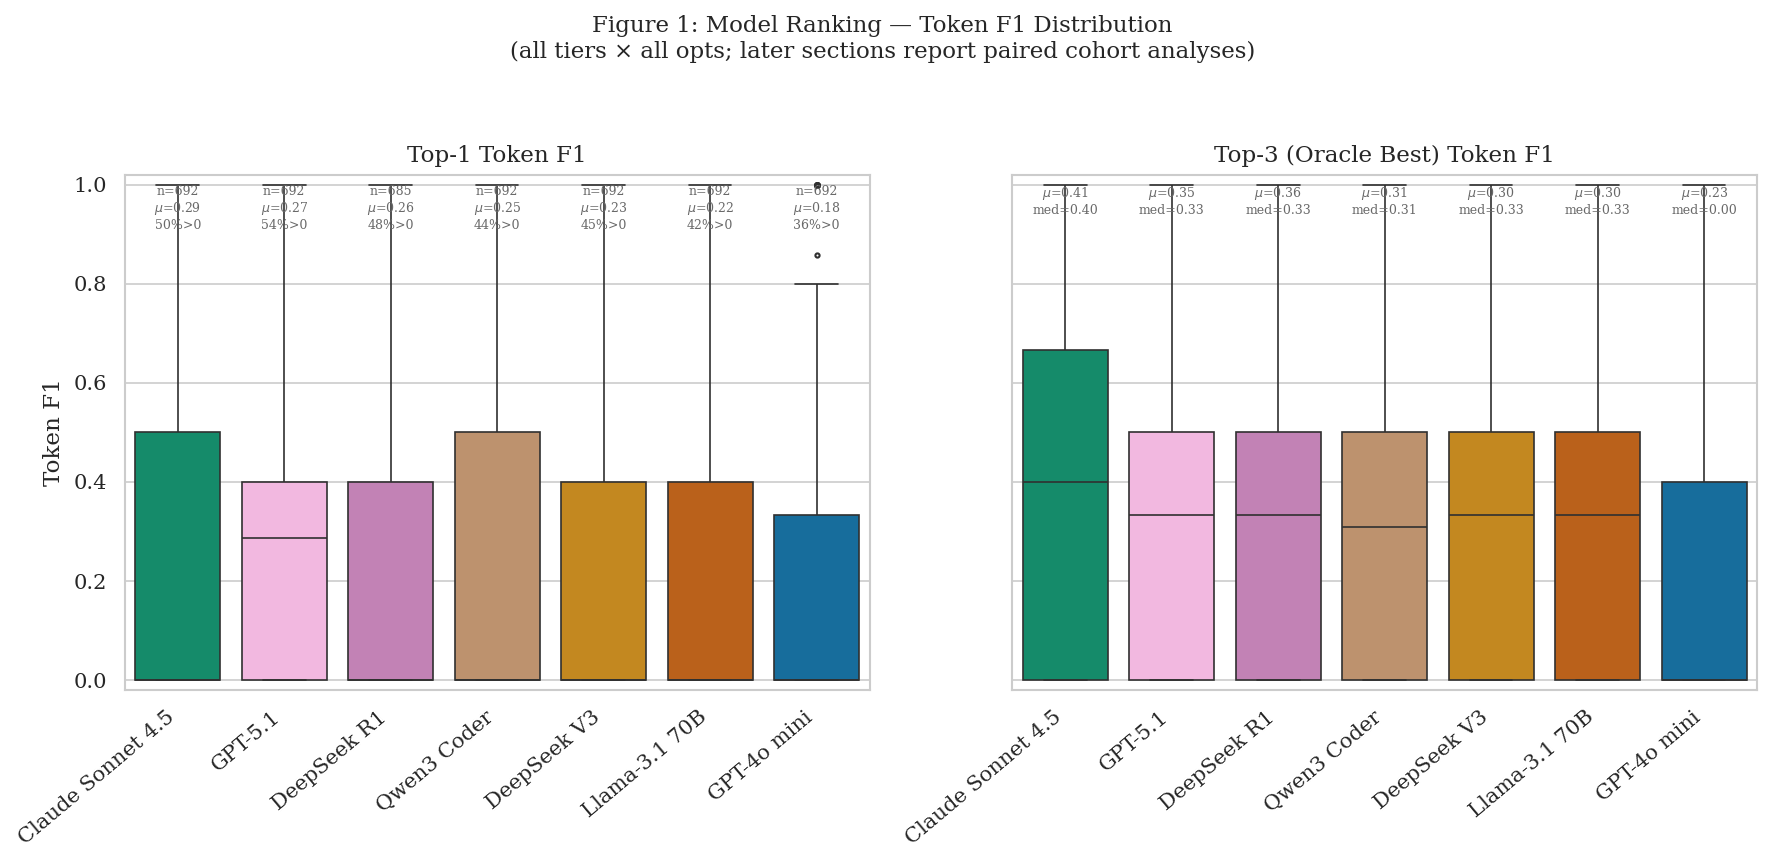

In [32]:
# ── §3: Model ranking table + box plot ────────────────────────────────────────

# Ranking table with bootstrap CIs
rank_rows = []
for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label]
    f1 = mdf["token_f1"].dropna()
    ci_lo, ci_hi = bootstrap_ci(f1)

    topk = mdf["token_f1_topk"].dropna()
    ci_topk_lo, ci_topk_hi = bootstrap_ci(topk)

    pct_nonzero = (f1 > 0).mean() * 100

    rank_rows.append({
        "Model":            label,
        "n":                len(f1),
        "F1 mean":          f1.mean(),
        "F1 [95% CI]":      f"[{ci_lo:.3f}, {ci_hi:.3f}]",
        "F1 median":        f1.median(),
        "% non-zero":       pct_nonzero,
        "EM%":              mdf["exact_match"].mean() * 100,
        "F1-topk mean":     topk.mean() if len(topk) else np.nan,
        "F1-topk [95% CI]": f"[{ci_topk_lo:.3f}, {ci_topk_hi:.3f}]" if len(topk) else "—",
        "Uplift mean":      mdf["topk_uplift"].dropna().mean() if mdf["topk_uplift"].notna().any() else np.nan,
    })

df_rank = pd.DataFrame(rank_rows).sort_values("F1 mean", ascending=False)
print("Model ranking (all tiers × all opts):")
display(df_rank)

# ── Figure 1: Box plot — top-1 and top-k F1 per model ───────────────────────
model_order = df_rank["Model"].tolist()

fig, axes = plt.subplots(1, 2, figsize=(12, 5.5), sharey=True)

# Top-1 F1
sns.boxplot(
    data=df, x="model_label", y="token_f1", order=model_order,
    palette=MODEL_PALETTE, ax=axes[0], fliersize=2, linewidth=0.8,
)
axes[0].set_title("Top-1 Token F1")
axes[0].set_xlabel("")
axes[0].set_ylabel("Token F1")
axes[0].set_ylim(-0.02, 1.02)
axes[0].tick_params(axis="x", rotation=40)
for tick in axes[0].get_xticklabels():
    tick.set_ha("right")
# Annotate: n, mean, % non-zero (more informative than median for zero-inflated data)
for i, label in enumerate(model_order):
    sub = df.loc[df["model_label"] == label, "token_f1"].dropna()
    mu = sub.mean()
    pnz = (sub > 0).mean() * 100
    axes[0].annotate(f"n={len(sub)}\n$\\mu$={mu:.2f}\n{pnz:.0f}%>0",
                     xy=(i, 1.0), fontsize=6, ha="center", va="top",
                     color="dimgrey")

# Top-k F1
topk_df = df.dropna(subset=["token_f1_topk"])
if len(topk_df) > 0:
    sns.boxplot(
        data=topk_df, x="model_label", y="token_f1_topk", order=model_order,
        palette=MODEL_PALETTE, ax=axes[1], fliersize=2, linewidth=0.8,
    )
    axes[1].set_title("Top-3 (Oracle Best) Token F1")
    axes[1].set_xlabel("")
    axes[1].set_ylim(-0.02, 1.02)
    axes[1].tick_params(axis="x", rotation=40)
    for tick in axes[1].get_xticklabels():
        tick.set_ha("right")
    for i, label in enumerate(model_order):
        sub = topk_df.loc[topk_df["model_label"] == label, "token_f1_topk"].dropna()
        mu = sub.mean()
        med = sub.median()
        axes[1].annotate(f"$\\mu$={mu:.2f}\nmed={med:.2f}",
                         xy=(i, 1.0), fontsize=6, ha="center", va="top",
                         color="dimgrey")

fig.suptitle("Figure 1: Model Ranking — Token F1 Distribution\n"
             "(all tiers × all opts; later sections report paired cohort analyses)",
             y=1.04, fontsize=11)
fig.tight_layout()
savefig(fig, "fig01_model_ranking")
plt.show()

## §4 — Top-1 vs Top-K Uplift — RQ3 (Figure 2)

Does the top-3 shortlist improve over the top-1 prediction?

**Redesign:** The original overlaid histogram was unreadable (density spike at 0 dominates).
Replaced with an **ECDF** plot — the fraction above 0 is directly readable.

In [33]:
# ── §4: Top-K uplift analysis (RQ3) ──────────────────────────────────────────
# NOTE: token_f1_topk = max(f1 across top-k candidates), so topk >= top1 by
# construction.  This means (a) there are ZERO negative differences, making
# the Wilcoxon one-sided test quasi-trivial and rank-biserial degenerate (=1.0).
# We report the p-value for completeness but emphasize effect-size measures:
# mean uplift with CI, % improved, and Cohen's d.

topk_df = df.dropna(subset=["token_f1_topk", "topk_uplift"]).copy()

# Validate best_candidate_index values
assert set(topk_df["best_candidate_index"].dropna().unique()) <= {0, 1, 2}, \
    f"Unexpected best_candidate_index values: {topk_df['best_candidate_index'].unique()}"

# Per-model uplift summary with CIs and effect sizes
uplift_rows = []
p_values_topk = []

for label in sorted(topk_df["model_label"].unique()):
    mdf = topk_df[topk_df["model_label"] == label]
    uplift = mdf["topk_uplift"]
    f1_top1 = mdf["token_f1"]
    f1_topk = mdf["token_f1_topk"]

    n = len(uplift)
    n_improved = (uplift > 0).sum()
    n_tied = (uplift == 0).sum()
    pct_improved = n_improved / n * 100
    mean_uplift = uplift.mean()
    ci_lo, ci_hi = bootstrap_ci(uplift)

    # Cohen's d (paired): mean difference / SD of differences
    sd_uplift = uplift.std(ddof=1)
    cohens_d = mean_uplift / sd_uplift if sd_uplift > 0 else np.nan

    # Wilcoxon signed-rank: top-k > top-1 (one-sided)
    # Quasi-trivial since topk >= top1 by construction; included for completeness.
    try:
        stat_w, p_w = stats.wilcoxon(f1_topk, f1_top1, alternative="greater")
    except ValueError:
        stat_w, p_w = np.nan, np.nan

    p_values_topk.append(p_w)

    uplift_rows.append({
        "Model":            label,
        "n":                n,
        "n improved":       n_improved,
        "n tied":           n_tied,
        "% improved":       f"{pct_improved:.1f}%",
        "Mean uplift":      mean_uplift,
        "Mean [95% CI]":    f"[{ci_lo:.4f}, {ci_hi:.4f}]",
        "Cohen's d":        cohens_d,
        "Wilcoxon p":       p_w,
    })

# Holm-Bonferroni correction
from statsmodels.stats.multitest import multipletests
if p_values_topk:
    rejected, p_adj, _, _ = multipletests(p_values_topk, method="holm")
    for i, row in enumerate(uplift_rows):
        row["p (Holm-adj)"] = p_adj[i]

df_uplift = pd.DataFrame(uplift_rows).sort_values("Mean uplift", ascending=False)
print("Top-K uplift summary (RQ3):")
print("  NOTE: topk = max(f1 over candidates), so uplift ≥ 0 by construction.")
print("  Wilcoxon confirms this property; Cohen's d measures practical magnitude.")
display(df_uplift)

# Candidate rank distribution: how often was best candidate at rank 1, 2, 3?
rank_dist = topk_df.groupby("model_label")["best_candidate_index"].value_counts(normalize=True).unstack(fill_value=0)
rank_dist.columns = [f"Rank {int(c)+1}" for c in rank_dist.columns]
print("\nBest candidate rank distribution (%): ")
display((rank_dist * 100).round(1))

Top-K uplift summary (RQ3):
  NOTE: topk = max(f1 over candidates), so uplift ≥ 0 by construction.
  Wilcoxon confirms this property; Cohen's d measures practical magnitude.


,Model,n,n improved,n tied,% improved,Mean uplift,Mean [95% CI],Cohen's d,Wilcoxon p,p (Holm-adj)
0,Claude Sonnet 4.5,692,175,517,25.3%,0.115531,"[0.0981, 0.1339]",0.484251,6.748188e-31,3.374094e-30
1,DeepSeek R1,685,183,502,26.7%,0.093913,"[0.0798, 0.1088]",0.486705,3.192881e-32,2.235016e-31
4,GPT-5.1,692,182,510,26.3%,0.079600,"[0.0673, 0.0921]",0.476924,5.259755e-32,3.155853e-31
5,Llama-3.1 70B,692,115,577,16.6%,0.075358,"[0.0623, 0.0892]",0.409413,3.573729e-21,1.072119e-20
2,DeepSeek V3,692,122,570,17.6%,0.074002,"[0.0601, 0.0887]",0.389003,3.635555e-22,1.454222e-21
6,Qwen3 Coder,692,94,598,13.6%,0.062538,"[0.0500, 0.0758]",0.357628,1.241974e-17,1.241974e-17
3,GPT-4o mini,692,102,590,14.7%,0.056193,"[0.0451, 0.0680]",0.368670,5.245206e-19,1.049041e-18



Best candidate rank distribution (%): 


,Rank 1,Rank 2,Rank 3
model_label,,,
Claude Sonnet 4.5,74.7,14.6,10.7
DeepSeek R1,73.3,14.7,12.0
DeepSeek V3,82.4,12.7,4.9
GPT-4o mini,85.3,9.4,5.3
GPT-5.1,73.7,16.8,9.5
Llama-3.1 70B,83.4,8.2,8.4
Qwen3 Coder,86.4,8.7,4.9


Uplift sanity: 0 negative, 79.9% zero, max=1.000
  → saved fig02_topk_uplift_ecdf.{pdf,png}


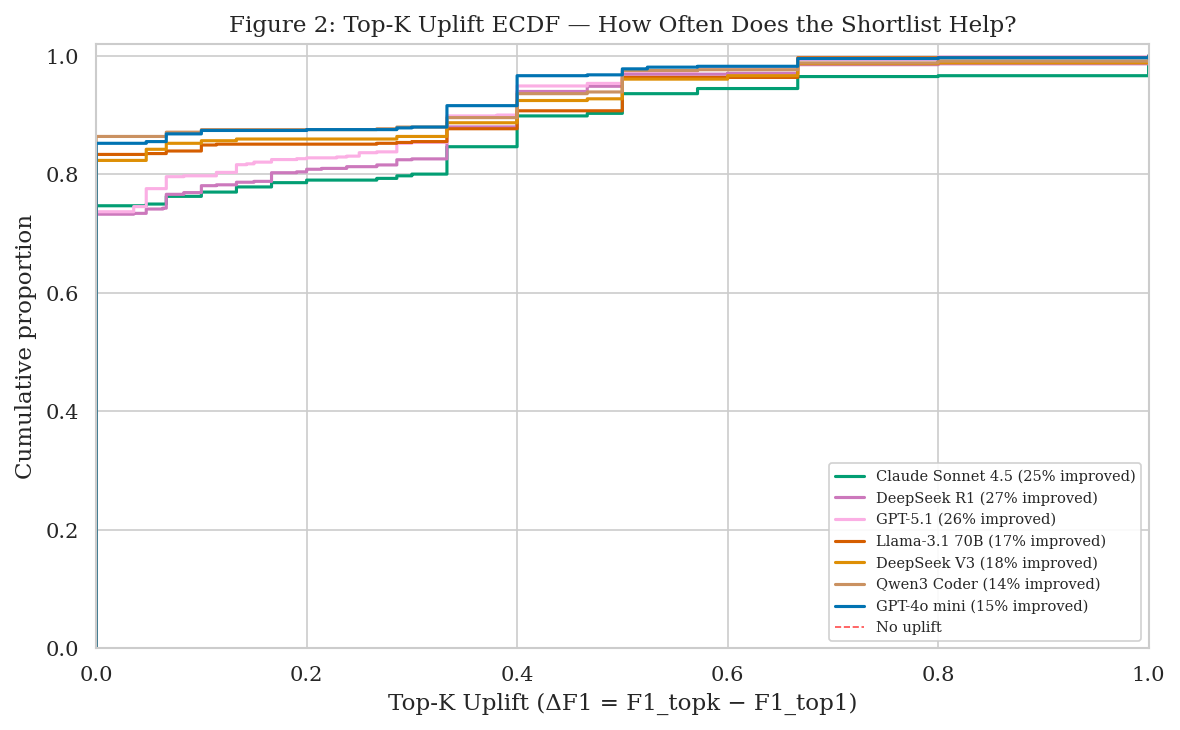

In [34]:
# ── Figure 2: Top-K Uplift ECDF ──────────────────────────────────────────────
# Sanity: uplift must be non-negative (topk = max over candidates)
n_neg = (topk_df["topk_uplift"] < -1e-9).sum()
assert n_neg == 0, f"Found {n_neg} negative uplift values — upstream bug!"
assert topk_df["topk_uplift"].max() <= 1.0 + 1e-9, "Uplift exceeds [0,1] bound"
pct_zero = (topk_df["topk_uplift"] == 0).mean() * 100
print(f"Uplift sanity: {n_neg} negative, {pct_zero:.1f}% zero, max={topk_df['topk_uplift'].max():.3f}")

# Order models by mean uplift (matching §4 table), not alphabetical
model_order_uplift = df_uplift["Model"].tolist()

fig, ax = plt.subplots(figsize=(8, 5))

for idx, label in enumerate(model_order_uplift):
    uplift = topk_df.loc[topk_df["model_label"] == label, "topk_uplift"].sort_values()
    ecdf_y = np.arange(1, len(uplift) + 1) / len(uplift)
    pct = (uplift > 0).mean() * 100
    ax.step(uplift, ecdf_y, where="post",
            label=f"{label} ({pct:.0f}% improved)",
            color=MODEL_PALETTE.get(label), linewidth=1.5)

ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.7, label="No uplift")
ax.set_xlabel("Top-K Uplift (ΔF1 = F1_topk − F1_top1)")
ax.set_ylabel("Cumulative proportion")
ax.set_title("Figure 2: Top-K Uplift ECDF — How Often Does the Shortlist Help?")
ax.legend(loc="lower right", fontsize=7, framealpha=0.9)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.02)

fig.tight_layout()
savefig(fig, "fig02_topk_uplift_ecdf")
plt.show()

## §5 — Optimization Decay — RQ1 (Figures 3–5)

Does LLM naming accuracy degrade with compiler optimization level?

**Sub-analyses:**
- §5a: Aggregate (unpaired) mean F1 per opt level with bootstrap CIs
- §5b: Paired cohort construction using stable keys
- §5c: Per-function delta distribution (Raincloud plot)
- §5d: Statistical tests with effect sizes and Holm correction
- §5e: Heatmap summary

  → saved fig03_opt_decay_line.{pdf,png}


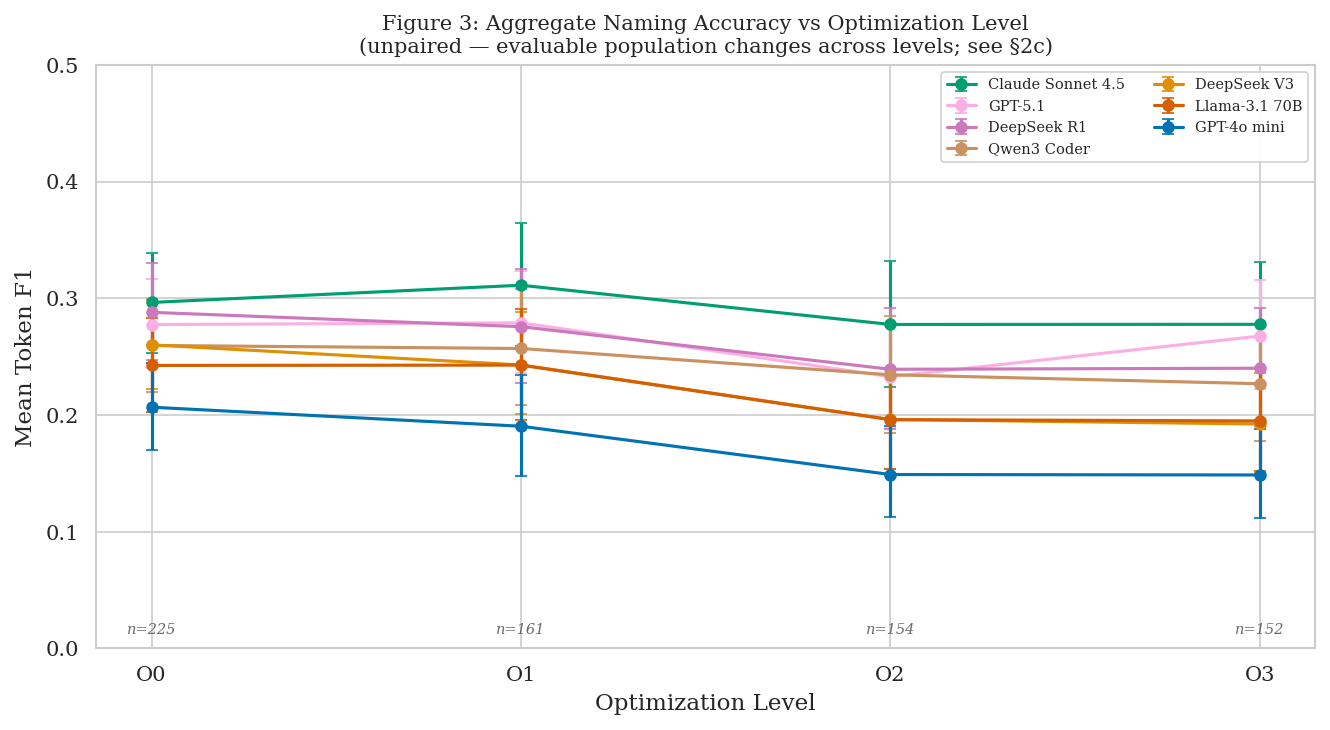

In [35]:
# ── §5a: Aggregate opt decay line plot (Figure 3) ────────────────────────────
# Unpaired means — uses ALL data at each opt level (not just the paired cohort).
# NOTE: the evaluable population changes across opt levels (see §2c attrition
# funnel), so these curves mix true difficulty shift with cohort drift.

opt_agg_rows = []
for label in sorted(df["model_label"].unique()):
    for opt in OPT_ORDER:
        subset = df[(df["model_label"] == label) & (df["opt"] == opt)]["token_f1"].dropna()
        if len(subset) == 0:
            continue
        ci_lo, ci_hi = bootstrap_ci(subset)
        opt_agg_rows.append({
            "Model": label, "opt": opt,
            "mean": subset.mean(), "median": subset.median(),
            "ci_lo": ci_lo, "ci_hi": ci_hi,
            "n": len(subset),
        })

df_opt_agg = pd.DataFrame(opt_agg_rows)

# ── Figure 3: Aggregate Decay — error bars instead of fill bands ─────────────
fig, ax = plt.subplots(figsize=(9, 5))
opt_idx = {o: i for i, o in enumerate(OPT_ORDER)}

# Use the ranking order from §3 for legend consistency
model_order_decay = df_rank["Model"].tolist()

for i_m, label in enumerate(model_order_decay):
    mdf = df_opt_agg[df_opt_agg["Model"] == label].sort_values("opt", key=lambda s: s.map(opt_idx))
    x = mdf["opt"].map(opt_idx)
    yerr_lo = mdf["mean"] - mdf["ci_lo"]
    yerr_hi = mdf["ci_hi"] - mdf["mean"]
    color = MODEL_PALETTE.get(label)
    ax.errorbar(x, mdf["mean"], yerr=[yerr_lo, yerr_hi],
                marker="o", label=label, color=color,
                linewidth=1.5, capsize=3, capthick=0.8, markersize=5)

# n= annotation at bottom — shared across models (same per opt)
n_by_opt = df_opt_agg.groupby("opt")["n"].first()
for opt_name in OPT_ORDER:
    if opt_name in n_by_opt.index:
        ax.annotate(f"n={n_by_opt[opt_name]:.0f}", xy=(opt_idx[opt_name], 0.01),
                    fontsize=7, ha="center", va="bottom", color="dimgrey",
                    fontstyle="italic")

ax.set_xticks(range(len(OPT_ORDER)))
ax.set_xticklabels(OPT_ORDER)
ax.set_ylabel("Mean Token F1")
ax.set_xlabel("Optimization Level")
ax.set_ylim(0, 0.50)
ax.set_title("Figure 3: Aggregate Naming Accuracy vs Optimization Level\n"
             "(unpaired — evaluable population changes across levels; see §2c)",
             fontsize=10)
ax.legend(fontsize=7, loc="upper right", ncol=2, framealpha=0.9)

fig.tight_layout()
savefig(fig, "fig03_opt_decay_line")
plt.show()

In [37]:
# ── §5b: Paired cohort construction ──────────────────────────────────────────
# Find functions (stable_key) present at all required opt levels per model.
# Convention: positive delta = degradation (baseline was better than O3).
# NOTE: This operates CROSS-TIER — a function that is GOLD at O0 but SILVER at
# O3 is still included.  This is intentional: tier reflects DWARF-alignment
# confidence, not a different ground truth.  The token_f1 metric compares against
# the same ground_truth_name regardless of tier.  See §2b tier-hopping diagnostic.

paired_data: Dict[str, pd.DataFrame] = {}  # model_label → wide DataFrame
paired_data_o1o3: Dict[str, pd.DataFrame] = {}  # O1-O3 only (includes BRONZE which lacks O0)

for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label].copy()
    # Exclude NaN / sentinel / empty stable keys
    mdf = mdf[mdf["stable_key"].notna()]
    mdf = mdf[mdf["stable_key"].str.len() > 0]
    mdf = mdf[~mdf["stable_key"].str.startswith("_unstable")]

    # Full cohort (O0-O3)
    keys_per_opt = mdf.groupby("opt")["stable_key"].apply(set)
    if set(OPT_ORDER).issubset(keys_per_opt.index):
        full_keys = set.intersection(*[keys_per_opt[o] for o in OPT_ORDER])
        if full_keys:
            cohort = mdf[mdf["stable_key"].isin(full_keys)]
            # Duplicate check: same (stable_key, opt) should appear once
            dup_max = cohort.groupby(["stable_key", "opt"]).size().max()
            if dup_max > 1 and label == sorted(df["model_label"].unique())[0]:
                print(f"⚠ max duplicates per (stable_key, opt): {dup_max}  — pivot uses mean")
            wide = cohort.pivot_table(
                index="stable_key", columns="opt", values="token_f1", aggfunc="mean"
            ).reindex(columns=OPT_ORDER)
            wide["delta_O0_O3"] = wide["O0"] - wide["O3"]
            wide["delta_O0_O1"] = wide["O0"] - wide["O1"]
            wide["delta_O1_O3"] = wide["O1"] - wide["O3"]
            wide["model"] = label
            paired_data[label] = wide

    # O1-O3 cohort (includes BRONZE which has no O0 under current filtering)
    o1o3 = ["O1", "O2", "O3"]
    if set(o1o3).issubset(keys_per_opt.index):
        o1o3_keys = set.intersection(*[keys_per_opt[o] for o in o1o3])
        if o1o3_keys:
            cohort_o = mdf[mdf["stable_key"].isin(o1o3_keys)]
            wide_o = cohort_o.pivot_table(
                index="stable_key", columns="opt", values="token_f1", aggfunc="mean"
            ).reindex(columns=o1o3)
            wide_o["delta_O1_O3"] = wide_o["O1"] - wide_o["O3"]
            wide_o["model"] = label
            paired_data_o1o3[label] = wide_o

print("Paired cohort sizes (full O0-O3):")
for label, w in paired_data.items():
    n_valid = w["delta_O0_O3"].notna().sum()
    print(f"  {label:25s}: {len(w)} functions  ({n_valid} valid deltas)")

print("\nPaired cohort sizes (O1-O3, includes BRONZE):")
for label, w in paired_data_o1o3.items():
    n_valid = w["delta_O1_O3"].notna().sum()
    print(f"  {label:25s}: {len(w)} functions  ({n_valid} valid deltas)")

# ── Cross-tier validity check: ground_truth stability ─────────────────────────
# For cross-tier pairing to be valid, the same stable_key must map to the same
# ground_truth across opt levels.  If it doesn't, paired deltas are comparing
# different functions — which would invalidate the cohort.
gt_col = "ground_truth" if "ground_truth" in df.columns else "ground_truth_name"
if gt_col in df.columns:
    gt_per_key = (df[df["stable_key"].notna() & (df["stable_key"].str.len() > 0)]
                  .groupby("stable_key")[gt_col].nunique())
    gt_unstable = gt_per_key[gt_per_key > 1]
    print(f"\n── Cross-tier validity: {gt_col} stability ──")
    print(f"Stable keys with >1 {gt_col} across opts: "
          f"{len(gt_unstable)} / {len(gt_per_key)}  ({len(gt_unstable)/len(gt_per_key)*100:.1f}%)")
    if len(gt_unstable) > 0:
        print("  ⚠ These keys have inconsistent ground truth — cross-tier deltas may be noisy.")
        print(f"  Examples: {list(gt_unstable.index[:5])}")
    else:
        print(f"  ✓ All stable keys map to a single {gt_col} — cross-tier pairing is valid.")
else:
    print("\n⚠ No ground_truth column found — cannot validate cross-tier pairing.")

⚠ max duplicates per (stable_key, opt): 2  — pivot uses mean
Paired cohort sizes (full O0-O3):
  Claude Sonnet 4.5        : 127 functions  (127 valid deltas)
  DeepSeek R1              : 122 functions  (122 valid deltas)
  DeepSeek V3              : 126 functions  (126 valid deltas)
  GPT-4o mini              : 127 functions  (127 valid deltas)
  GPT-5.1                  : 125 functions  (125 valid deltas)
  Llama-3.1 70B            : 125 functions  (125 valid deltas)
  Qwen3 Coder              : 126 functions  (126 valid deltas)

Paired cohort sizes (O1-O3, includes BRONZE):
  Claude Sonnet 4.5        : 128 functions  (128 valid deltas)
  DeepSeek R1              : 123 functions  (123 valid deltas)
  DeepSeek V3              : 127 functions  (127 valid deltas)
  GPT-4o mini              : 128 functions  (128 valid deltas)
  GPT-5.1                  : 126 functions  (126 valid deltas)
  Llama-3.1 70B            : 126 functions  (126 valid deltas)
  Qwen3 Coder              : 127 functi

── Zero-inflation diagnostic (per model) ──
  Model                         n  always-fail  some-signal  med_Δ(B)  deg(B)  imp(B)
  Claude Sonnet 4.5           127           48           79     0.000      17      17
  DeepSeek R1                 122           47           75     0.000      25      19
  DeepSeek V3                 126           57           69     0.000      25      13
  GPT-4o mini                 127           71           56     0.000      16       9
  GPT-5.1                     125           34           91     0.000      29      22
  Llama-3.1 70B               125           60           65     0.000      17       9
  Qwen3 Coder                 126           55           71     0.000      14      13
  → saved fig04_decay_raincloud.{pdf,png}


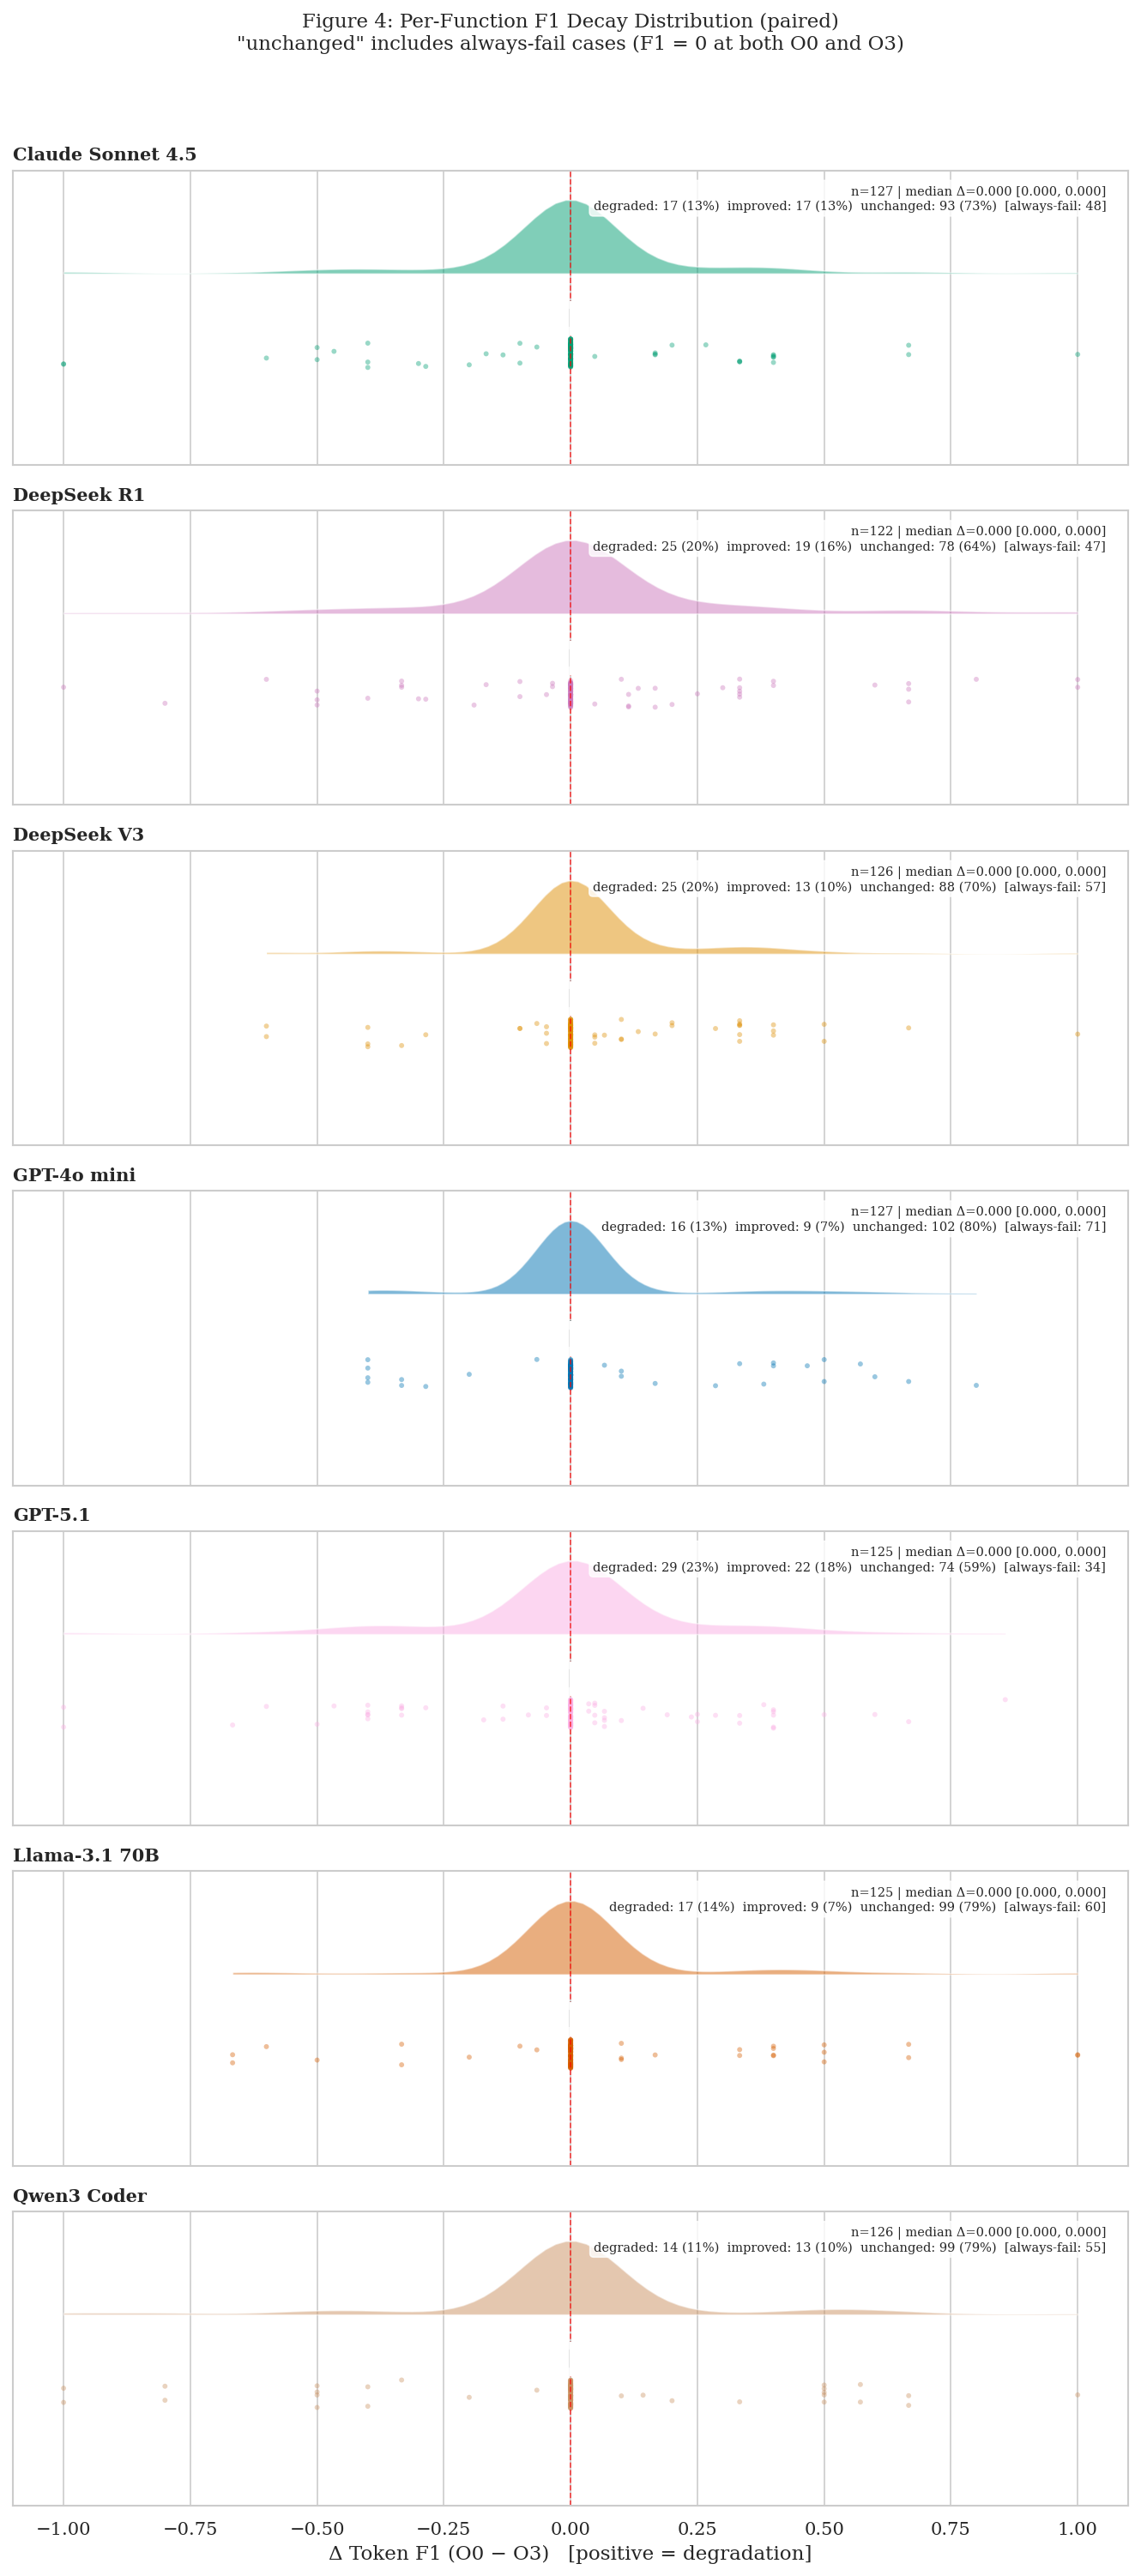

In [38]:
# ── §5c: Per-function delta distribution — Raincloud plot (Figure 4) ─────────
# Convention: delta > 0 means degradation (O0 was better than O3).

EPS = 1e-12  # for robust float-zero comparison

if paired_data:
    deltas = pd.concat(
        [w[["delta_O0_O3", "model"]].assign(stable_key=w.index) for w in paired_data.values()],
        ignore_index=True,
    )
    models_sorted = sorted(deltas["model"].unique())
    n_models = len(models_sorted)

    # ── Zero-inflation diagnostic ─────────────────────────────────────────────
    # If F1 is 0 at both O0 AND O3, delta=0 means "failed everywhere", not
    # "robust".  Split into always-fail (group A) vs some-signal (group B).
    print("── Zero-inflation diagnostic (per model) ──")
    print(f"  {'Model':25s}  {'n':>4s}  {'always-fail':>11s}  {'some-signal':>11s}  "
          f"{'med_Δ(B)':>8s}  {'deg(B)':>6s}  {'imp(B)':>6s}")
    zi_rows = []
    for label, w in paired_data.items():
        f1_max = w[["O0", "O3"]].max(axis=1)
        grp_a = (f1_max <= EPS).sum()   # always-fail
        grp_b = (f1_max > EPS).sum()    # some signal
        d_b = w.loc[f1_max > EPS, "delta_O0_O3"].dropna()
        med_b = d_b.median() if len(d_b) > 0 else float("nan")
        deg_b = (d_b > EPS).sum() if len(d_b) > 0 else 0
        imp_b = (d_b < -EPS).sum() if len(d_b) > 0 else 0
        zi_rows.append({"model": label, "n": len(w), "always_fail": grp_a,
                         "some_signal": grp_b, "med_delta_B": med_b,
                         "deg_B": deg_b, "imp_B": imp_b})
        print(f"  {label:25s}  {len(w):4d}  {grp_a:11d}  {grp_b:11d}  "
              f"{med_b:8.3f}  {deg_b:6d}  {imp_b:6d}")

    fig, axes = plt.subplots(n_models, 1, figsize=(9, 2.8 * n_models), sharex=True)
    if n_models == 1:
        axes = [axes]

    for ax, label in zip(axes, models_sorted):
        d = deltas.loc[deltas["model"] == label, "delta_O0_O3"].dropna()
        color = MODEL_PALETTE.get(label, "steelblue")

        # Half-violin (right side only)
        parts = ax.violinplot(d, positions=[0], vert=False, showmedians=False, showextrema=False)
        for pc in parts["bodies"]:
            # Clip to upper half for "raincloud" effect
            m = np.mean(pc.get_paths()[0].vertices[:, 1])
            pc.get_paths()[0].vertices[:, 1] = np.clip(
                pc.get_paths()[0].vertices[:, 1], m, None
            )
            pc.set_facecolor(color)
            pc.set_alpha(0.5)

        # Box plot (thin)
        bp = ax.boxplot(d, positions=[-0.15], vert=False, widths=0.12,
                        patch_artist=True, showfliers=False,
                        boxprops=dict(facecolor=color, alpha=0.7),
                        medianprops=dict(color="white", linewidth=1.5))

        # Jittered strip
        jitter = np.random.default_rng(42).uniform(-0.32, -0.22, size=len(d))
        ax.scatter(d, jitter, s=8, alpha=0.4, color=color, edgecolors="none")

        # Reference line at 0
        ax.axvline(0, color="red", linestyle="--", linewidth=0.8, alpha=0.7)

        # Annotations (epsilon-based zero comparison)
        n_deg = (d > EPS).sum()
        n_imp = (d < -EPS).sum()
        n_eq = (d.abs() <= EPS).sum()
        median_d = d.median()
        ci_lo, ci_hi = bootstrap_ci(d, statistic=np.median)

        # Also note always-fail fraction from zero-inflation check
        w_this = paired_data[label]
        f1_max = w_this[["O0", "O3"]].max(axis=1)
        n_always_fail = (f1_max <= EPS).sum()

        ann = (f"n={len(d)} | median Δ={median_d:.3f} [{ci_lo:.3f}, {ci_hi:.3f}]\n"
               f"degraded: {n_deg} ({n_deg/len(d)*100:.0f}%)  "
               f"improved: {n_imp} ({n_imp/len(d)*100:.0f}%)  "
               f"unchanged: {n_eq} ({n_eq/len(d)*100:.0f}%)"
               f"  [always-fail: {n_always_fail}]")
        ax.set_title(f"{label}", fontsize=10, loc="left", fontweight="bold")
        ax.annotate(ann, xy=(0.98, 0.95), xycoords="axes fraction",
                    fontsize=7, ha="right", va="top",
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
        ax.set_yticks([])

    axes[-1].set_xlabel("Δ Token F1 (O0 − O3)   [positive = degradation]")
    fig.suptitle("Figure 4: Per-Function F1 Decay Distribution (paired)\n"
                 "\"unchanged\" includes always-fail cases (F1 = 0 at both O0 and O3)",
                 y=1.02, fontsize=11)
    fig.tight_layout()
    savefig(fig, "fig04_decay_raincloud")
    plt.show()
else:
    print("⚠ No paired data available for raincloud plot.")

In [39]:
# ── §5d: Statistical tests with effect sizes ─────────────────────────────────
# All tests on the full paired cohort (O0-O3).
# Three complementary tests per model:
#   1. Wilcoxon signed-rank (O0 > O3): is performance at O0 systematically higher?
#   2. Friedman (repeated measures O0–O3): any systematic difference across levels?
#   3. Per-function linear slope test: is there consistent monotonic decay?
# Family-wise error controlled via Holm-Bonferroni across all model×test comparisons.

test_rows = []
# Keyed p-values: (model, test_name) → raw p.  Avoids fragile flat-list alignment.
p_value_map: Dict[tuple, float] = {}

for label in sorted(paired_data.keys()):
    w = paired_data[label]
    n = len(w)

    # ── Wilcoxon signed-rank: O0 > O3 (one-sided) ────────────────────────
    try:
        stat_w, p_w = stats.wilcoxon(w["O0"], w["O3"], alternative="greater")
        rb_w = rank_biserial(w["O0"].values, w["O3"].values)
    except ValueError:
        stat_w, p_w, rb_w = np.nan, np.nan, np.nan

    # ── Friedman: repeated measures across O0–O3 ─────────────────────────
    try:
        friedman_data = [w[opt].values for opt in OPT_ORDER]
        stat_f, p_f = stats.friedmanchisquare(*friedman_data)
        # Kendall's W effect size = chi2 / (n * (k-1))
        k = len(OPT_ORDER)
        kendall_w = stat_f / (n * (k - 1))
    except ValueError:
        stat_f, p_f, kendall_w = np.nan, np.nan, np.nan

    # ── Per-function slopes: F1 ~ opt_index (0,1,2,3 = equal spacing) ───
    # Slope > 0 = improvement with optimization, < 0 = decay.
    opt_indices = np.array([0, 1, 2, 3])
    slopes = []
    for idx in w.index:
        f1_vals = w.loc[idx, OPT_ORDER].values.astype(float)
        if np.all(np.isfinite(f1_vals)):
            slope = np.polyfit(opt_indices, f1_vals, 1)[0]
            slopes.append(slope)

    if len(slopes) >= 3:
        median_slope = np.median(slopes)
        # One-sample Wilcoxon: are slopes significantly < 0 (monotonic decay)?
        # Explicit two-array form for clarity.
        slopes_arr = np.array(slopes)
        stat_slope, p_slope = stats.wilcoxon(
            slopes_arr, np.zeros_like(slopes_arr), alternative="less"
        )
    else:
        median_slope, p_slope = np.nan, np.nan

    # % degraded (O0 > O3) for interpretability
    d_delta = w["delta_O0_O3"].dropna()
    pct_deg = (d_delta > EPS).mean() * 100 if len(d_delta) > 0 else np.nan

    # Store keyed p-values
    p_value_map[(label, "Wilcoxon p")] = p_w
    p_value_map[(label, "Friedman p")] = p_f
    p_value_map[(label, "Slope Wilcoxon p")] = p_slope

    test_rows.append({
        "Model":              label,
        "n (paired)":         n,
        "% degraded":         pct_deg,
        # Wilcoxon
        "Wilcoxon p":         p_w,
        "rank-biserial r":    rb_w,
        # Friedman
        "Friedman χ²":        stat_f,
        "Friedman p":         p_f,
        "Kendall's W":        kendall_w,
        # Slopes
        "Median slope":       median_slope,
        "Slope Wilcoxon p":   p_slope,
    })

# ── Holm-Bonferroni correction (keyed approach for robustness) ────────────────
# Build list of (key, p) pairs, filter NaN, correct, write back by key.
keyed_p = [(k, v) for k, v in p_value_map.items() if np.isfinite(v)]
if keyed_p:
    keys_order, raw_p = zip(*keyed_p)
    _, p_adj_all, _, _ = multipletests(list(raw_p), method="holm")
    adj_map = dict(zip(keys_order, p_adj_all))
    for row in test_rows:
        for p_col in ["Wilcoxon p", "Friedman p", "Slope Wilcoxon p"]:
            adj = adj_map.get((row["Model"], p_col))
            if adj is not None:
                row[f"{p_col} (adj)"] = adj

df_tests = pd.DataFrame(test_rows)
print("Statistical tests — Optimization decay (RQ1):")
print(f"  Total comparisons: {len(keyed_p)} → Holm-Bonferroni correction applied")
display(df_tests)

Statistical tests — Optimization decay (RQ1):
  Total comparisons: 21 → Holm-Bonferroni correction applied


,Model,n (paired),% degraded,Wilcoxon p,rank-biserial r,Friedman χ²,Friedman p,Kendall's W,Median slope,Slope Wilcoxon p,Wilcoxon p (adj),Friedman p (adj),Slope Wilcoxon p (adj)
0,Claude Sonnet 4.5,127,13.385827,0.503416,-0.001681,0.049505,0.997114,0.000130,0.000000e+00,0.013405,1.000000,1.000000,0.241284
1,DeepSeek R1,122,20.491803,0.141359,0.185859,7.097015,0.068869,0.019391,0.000000e+00,0.096039,1.000000,0.895297,1.000000
2,DeepSeek V3,126,19.841270,0.029933,0.349528,5.621359,0.131558,0.014871,0.000000e+00,0.003390,0.478923,1.000000,0.064412
3,GPT-4o mini,127,12.598425,0.038711,0.403077,5.476415,0.140056,0.014374,0.000000e+00,0.002718,0.580668,1.000000,0.054364
4,GPT-5.1,125,23.200000,0.520587,-0.008296,3.549708,0.314372,0.009466,-4.002300e-17,0.085802,1.000000,1.000000,1.000000
5,Llama-3.1 70B,125,13.600000,0.053079,0.361823,5.298165,0.151221,0.014128,0.000000e+00,0.000523,0.743106,1.000000,0.010981
6,Qwen3 Coder,126,11.111111,0.451967,0.026455,0.782143,0.853733,0.002069,0.000000e+00,0.016462,1.000000,1.000000,0.279856


  → saved fig05_decay_heatmap.{pdf,png}


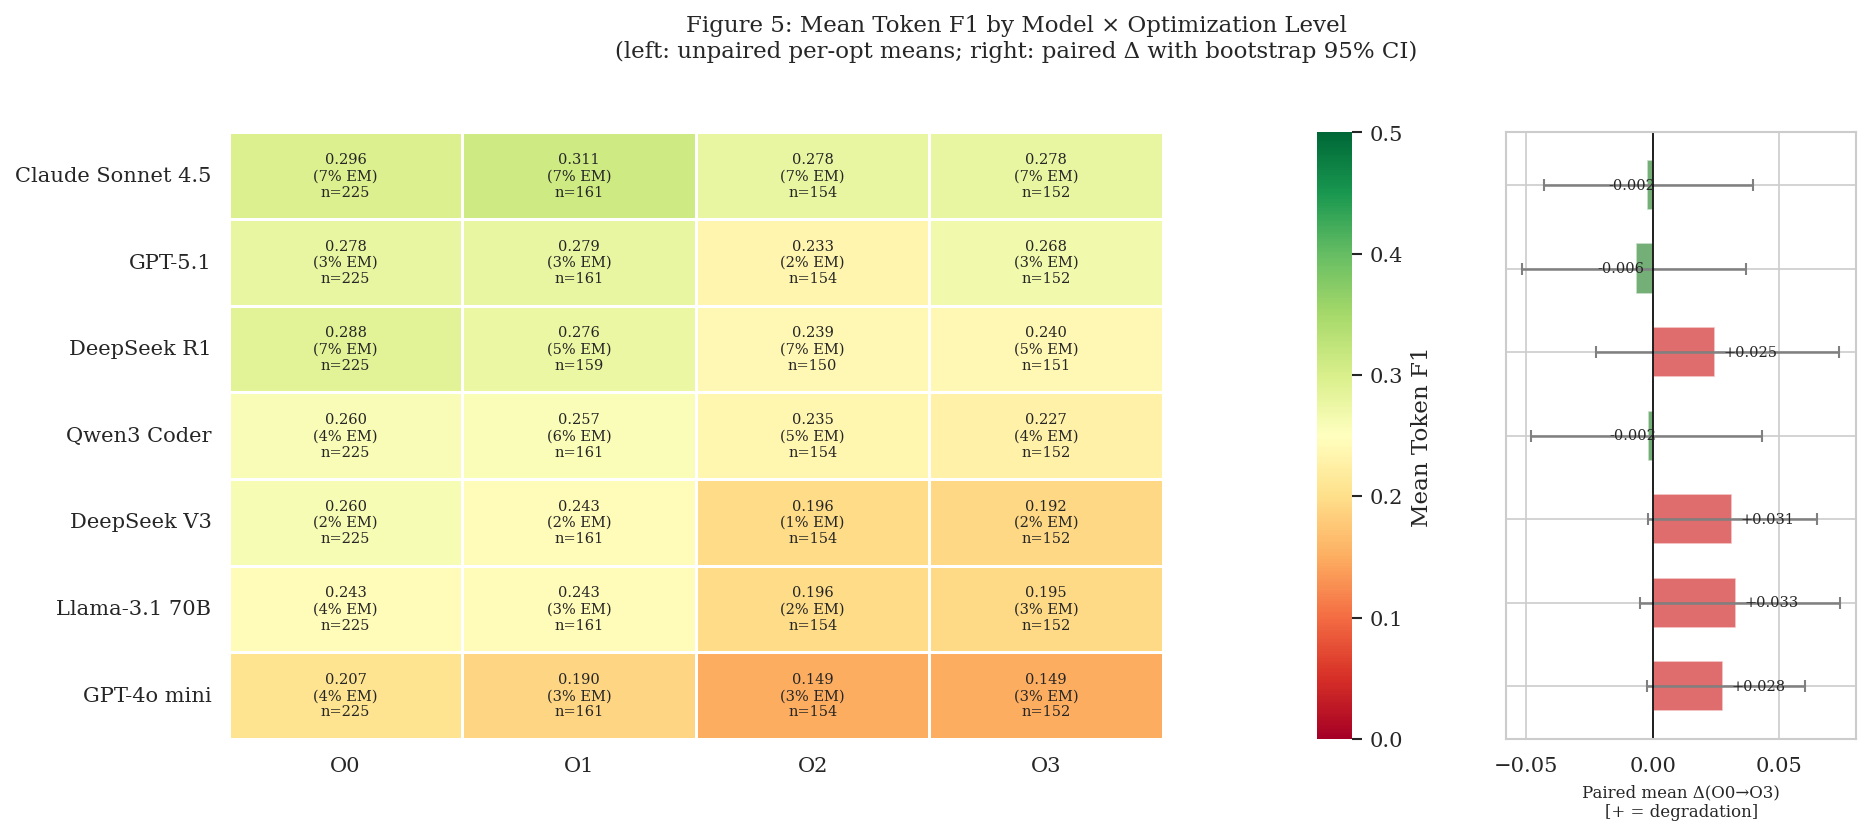

In [41]:
# ── §5e: Heatmap — mean F1 by (model × opt) + paired delta bar (Figure 5) ────
# Panel A: unpaired mean F1 heatmap (O0–O3).
# Panel B: paired mean Δ(O0→O3) with bootstrap CI — separate from the colormap
#          because the delta scale (≈ ±0.03) is incomparable with F1 (0–1).

# ── Build heatmap data (unpaired) ─────────────────────────────────────────────
hm_rows = []
for label in sorted(df["model_label"].unique()):
    for opt in OPT_ORDER:
        subset = df[(df["model_label"] == label) & (df["opt"] == opt)]
        f1 = subset["token_f1"].dropna()
        em = subset["exact_match"].mean() * 100 if len(subset) > 0 else np.nan
        hm_rows.append({
            "Model": label, "opt": opt,
            "F1": f1.mean() if len(f1) else np.nan,
            "EM%": em,
            "n": len(f1),
        })

df_hm = pd.DataFrame(hm_rows)

# Pivots for heatmap
hm_f1 = df_hm.pivot(index="Model", columns="opt", values="F1").reindex(columns=OPT_ORDER)
hm_em = df_hm.pivot(index="Model", columns="opt", values="EM%").reindex(columns=OPT_ORDER)
hm_n  = df_hm.pivot(index="Model", columns="opt", values="n").reindex(columns=OPT_ORDER)

# Order models by overall mean F1 (descending)
model_order_hm = hm_f1.mean(axis=1).sort_values(ascending=False).index.tolist()
hm_f1 = hm_f1.reindex(model_order_hm)
hm_em = hm_em.reindex(model_order_hm)
hm_n  = hm_n.reindex(model_order_hm)

# Annotation strings: "F1\n(EM%)\nn=N"
annot = hm_f1.copy().astype(str)
for model in hm_f1.index:
    for col in OPT_ORDER:
        f1_val = hm_f1.loc[model, col]
        em_val = hm_em.loc[model, col]
        n_val  = hm_n.loc[model, col]
        if np.isnan(f1_val):
            annot.loc[model, col] = "—"
        else:
            annot.loc[model, col] = f"{f1_val:.3f}\n({em_val:.0f}% EM)\nn={n_val:.0f}"

# ── Paired delta + CI per model ───────────────────────────────────────────────
delta_rows = []
for label in model_order_hm:
    if label in paired_data:
        d = paired_data[label]["delta_O0_O3"].dropna()
        mu = d.mean()
        ci_lo, ci_hi = bootstrap_ci(d)
        delta_rows.append({"Model": label, "mean_delta": mu, "ci_lo": ci_lo, "ci_hi": ci_hi})
    else:
        delta_rows.append({"Model": label, "mean_delta": np.nan, "ci_lo": np.nan, "ci_hi": np.nan})
df_delta = pd.DataFrame(delta_rows)

# ── Plot: 2-panel figure ─────────────────────────────────────────────────────
fig = plt.figure(figsize=(14, max(3.5, len(hm_f1) * 0.75)))
gs = fig.add_gridspec(1, 3, width_ratios=[4, 0.15, 1.5], wspace=0.35)
ax_hm  = fig.add_subplot(gs[0, 0])
ax_cb  = fig.add_subplot(gs[0, 1])   # dedicated colorbar axis
ax_bar = fig.add_subplot(gs[0, 2])

# Panel A: heatmap (O0–O3 only)
hmap = sns.heatmap(
    hm_f1, annot=annot, fmt="", cmap="RdYlGn", vmin=0, vmax=0.5,
    linewidths=0.5, ax=ax_hm, cbar_ax=ax_cb, cbar_kws={"label": "Mean Token F1"},
    annot_kws={"fontsize": 7},
)
ax_hm.set_ylabel("")
ax_hm.set_xlabel("")

# Panel B: horizontal bar for paired Δ(O0→O3) with CI
y_pos = np.arange(len(df_delta))
colors = ["#d32f2f" if v > 0 else "#388e3c" for v in df_delta["mean_delta"]]
xerr_lo = df_delta["mean_delta"] - df_delta["ci_lo"]
xerr_hi = df_delta["ci_hi"] - df_delta["mean_delta"]
ax_bar.barh(y_pos, df_delta["mean_delta"], color=colors, alpha=0.7, height=0.6,
            xerr=[xerr_lo.values, xerr_hi.values], ecolor="gray", capsize=3)
ax_bar.axvline(0, color="black", linewidth=0.8, linestyle="-")
ax_bar.set_yticks(y_pos)
ax_bar.set_yticklabels([])
ax_bar.invert_yaxis()
ax_bar.set_xlabel("Paired mean Δ(O0→O3)\n[+ = degradation]", fontsize=8)
# Annotate values
for i, row in df_delta.iterrows():
    if np.isfinite(row["mean_delta"]):
        ax_bar.annotate(
            f"{row['mean_delta']:+.3f}",
            xy=(row["mean_delta"], i),
            xytext=(4, 0), textcoords="offset points",
            fontsize=7, va="center", ha="left" if row["mean_delta"] >= 0 else "right",
        )

fig.suptitle("Figure 5: Mean Token F1 by Model × Optimization Level\n"
             "(left: unpaired per-opt means; right: paired Δ with bootstrap 95% CI)",
             fontsize=11, y=1.03)
savefig(fig, "fig05_decay_heatmap", bbox_inches="tight")
plt.show()

## §6 — GT Confidence as Confound — RQ2 (Figure 6)

Does the ground-truth confidence tier (GOLD/SILVER/BRONZE) confound the optimization decay results?

**Handling:**
- BRONZE has no O0 baseline → line starts at O1, annotated explicitly
- Error bars: 95% bootstrap CIs
- Post-hoc: Dunn's test after significant Kruskal-Wallis

  → saved fig06_tier_opt_interaction.{pdf,png}


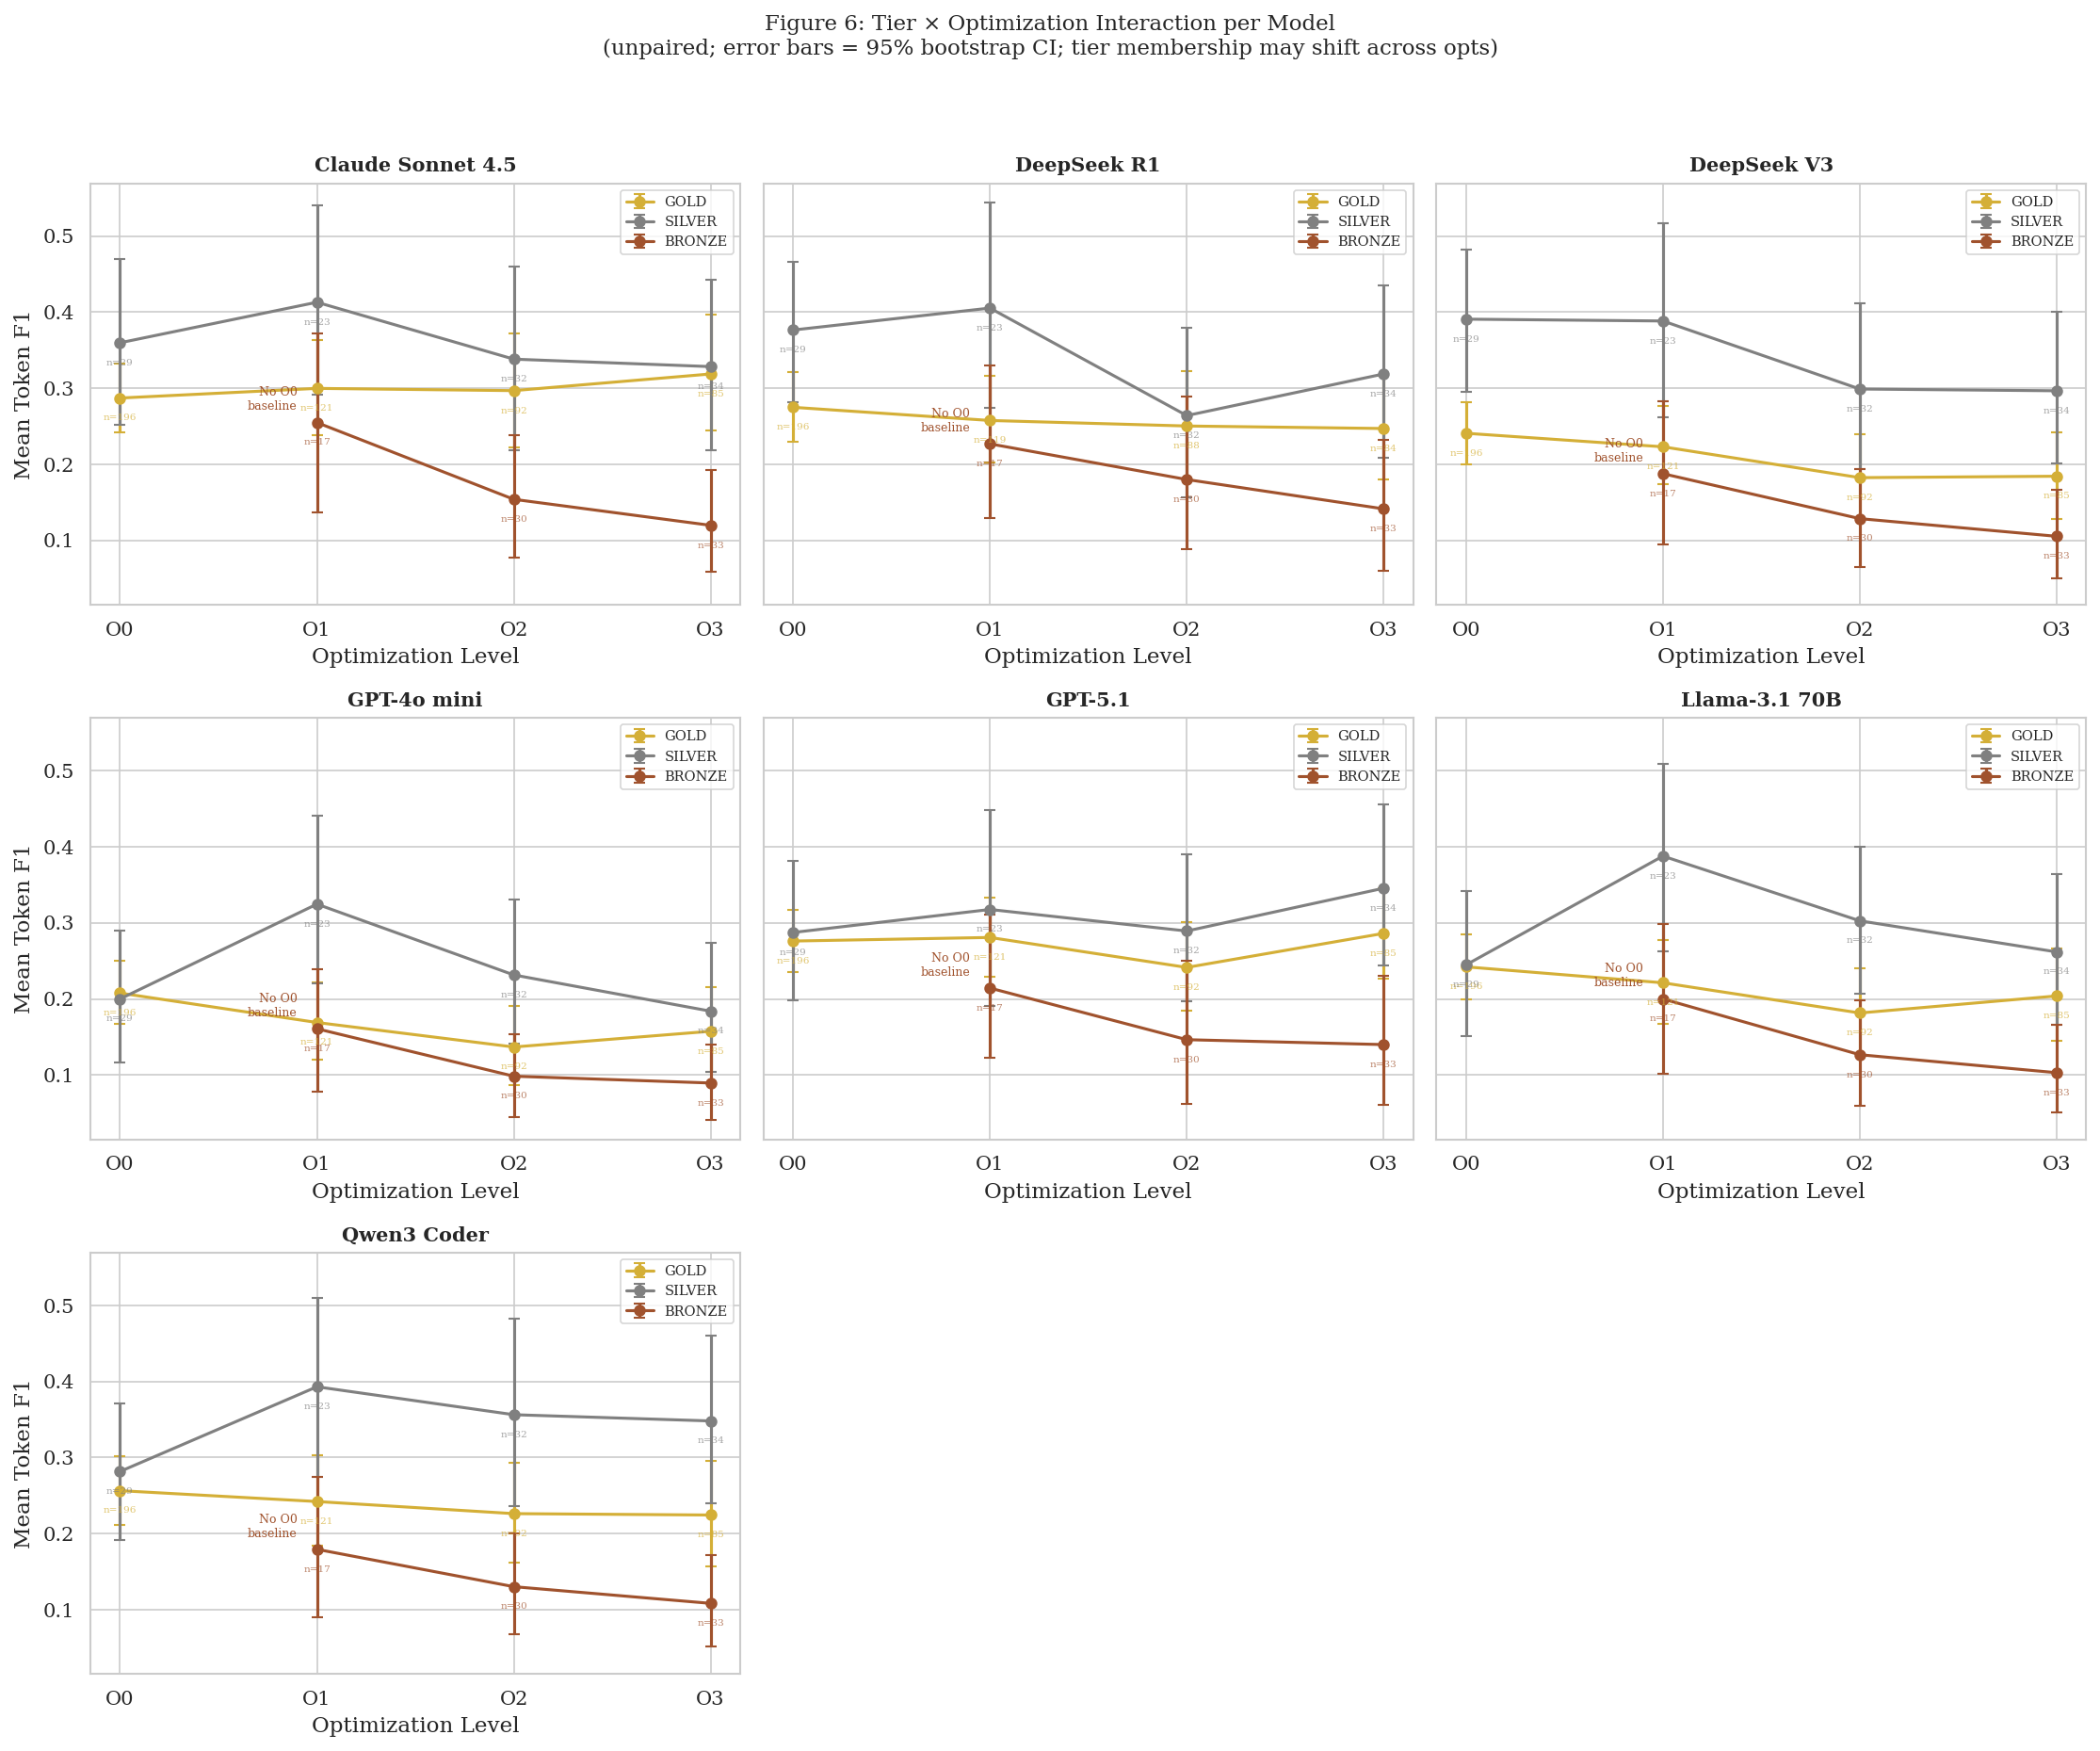

In [42]:
# ── §6: Tier × Opt Interaction (Figure 6) ────────────────────────────────────
# Descriptive: unpaired mean Token-F1 per (model, tier, opt) with bootstrap CIs.
# NOTE: tier membership can shift with optimization (tier-hopping, see §2b).
# This plot is therefore descriptive, not paired.

models_list = sorted(df["model_label"].unique())
n_models = len(models_list)
ncols = min(3, n_models)
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
axes_flat = np.atleast_1d(axes).flatten()

for idx, label in enumerate(models_list):
    ax = axes_flat[idx]
    mdf = df[df["model_label"] == label]

    for tier in TIER_ORDER:
        tdf = mdf[mdf["tier"] == tier]
        means = []
        cis_lo = []
        cis_hi = []
        opts_present = []
        ns = []

        for opt in OPT_ORDER:
            subset = tdf.loc[tdf["opt"] == opt, "token_f1"].dropna()
            if len(subset) < 2:
                continue
            opts_present.append(opt)
            means.append(subset.mean())
            lo, hi = bootstrap_ci(subset)
            cis_lo.append(lo)
            cis_hi.append(hi)
            ns.append(len(subset))

        if opts_present:
            x = [OPT_ORDER.index(o) for o in opts_present]
            ax.errorbar(
                x, means,
                yerr=[np.array(means) - np.array(cis_lo),
                      np.array(cis_hi) - np.array(means)],
                marker="o", label=tier, color=TIER_COLORS[tier],
                linewidth=1.5, capsize=3, markersize=5,
            )
            # Annotate n= at each point (small, below marker)
            for xi, mi, ni in zip(x, means, ns):
                ax.annotate(f"n={ni}", xy=(xi, mi), fontsize=5,
                            ha="center", va="top", color=TIER_COLORS[tier],
                            xytext=(0, -8), textcoords="offset points", alpha=0.7)
            # If BRONZE starts after O0, annotate
            if tier == "BRONZE" and opts_present[0] != "O0":
                ax.annotate("No O0\nbaseline", xy=(x[0], means[0]),
                            fontsize=6, ha="right", va="bottom", color=TIER_COLORS[tier],
                            xytext=(-10, 5), textcoords="offset points")

    ax.set_xticks(range(len(OPT_ORDER)))
    ax.set_xticklabels(OPT_ORDER)
    ax.set_title(label, fontsize=10, fontweight="bold")
    ax.set_xlabel("Optimization Level")
    if idx % ncols == 0:
        ax.set_ylabel("Mean Token F1")
    ax.legend(fontsize=7)

# Hide unused axes
for idx in range(n_models, len(axes_flat)):
    axes_flat[idx].set_visible(False)

fig.suptitle("Figure 6: Tier × Optimization Interaction per Model\n"
             "(unpaired; error bars = 95% bootstrap CI; tier membership may shift across opts)",
             y=1.03, fontsize=11)
fig.tight_layout()
savefig(fig, "fig06_tier_opt_interaction")
plt.show()

In [45]:
# ── §6b: Kruskal-Wallis + Dunn's post-hoc per model ──────────────────────────

try:
    from scikit_posthocs import posthoc_dunn
    HAS_POSTHOC = True
except ImportError:
    try:
        from scikit_posthocs import posthoc_dunn  # type: ignore
        HAS_POSTHOC = True
    except ImportError:
        HAS_POSTHOC = False
        print("⚠ scikit-posthocs not installed — skipping Dunn's test.")
        print("  Install with: pip install scikit-posthocs")

kw_rows = []
for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label]

    # Build groups as a dict to preserve tier identity
    tier_groups = {
        t: mdf.loc[mdf["tier"] == t, "token_f1"].dropna()
        for t in TIER_ORDER
    }
    tier_groups = {t: g for t, g in tier_groups.items() if len(g) >= 2}

    if len(tier_groups) < 2:
        kw_rows.append({"Model": label, "K-W H": np.nan, "K-W p": np.nan, "ε²": np.nan})
        continue

    stat_h, p_h = stats.kruskal(*tier_groups.values())
    # Epsilon-squared effect size: ε² = H / (n-1)  [Tomczak & Tomczak 2014]
    n_total = sum(len(g) for g in tier_groups.values())
    eps_sq = stat_h / (n_total - 1)

    row = {"Model": label, "K-W H": stat_h, "K-W p": p_h, "ε²": eps_sq}

    # Dunn's post-hoc (Holm-corrected), conditional on significant omnibus
    tiers_present = list(tier_groups.keys())
    if HAS_POSTHOC and p_h < 0.05 and len(tiers_present) >= 2:
        dunn_df = mdf[mdf["tier"].isin(tiers_present)][["tier", "token_f1"]].dropna()
        dunn_result = posthoc_dunn(dunn_df, val_col="token_f1", group_col="tier", p_adjust="holm")
        for i, t1 in enumerate(tiers_present):
            for t2 in tiers_present[i+1:]:
                row[f"Dunn {t1} vs {t2}"] = dunn_result.loc[t1, t2]

    kw_rows.append(row)

df_kw = pd.DataFrame(kw_rows)

# Holm-correct Kruskal-Wallis p-values across models (family-wise error control)
valid_p = df_kw["K-W p"].dropna()
if len(valid_p) > 1:
    from statsmodels.stats.multitest import multipletests
    rejected, p_adj_kw, _, _ = multipletests(valid_p.values, method="holm")
    df_kw.loc[valid_p.index, "K-W p (Holm)"] = p_adj_kw
else:
    df_kw["K-W p (Holm)"] = df_kw["K-W p"]

print("Kruskal-Wallis test: does F1 differ across tiers?")
print(f"  (ε² = H/(n−1), Tomczak & Tomczak 2014; Holm correction across {len(valid_p)} models)")
display(df_kw)

# Per-tier means summary
print("\nMean F1 per (model, tier):")
tier_means = df.groupby(["model_label", "tier"])["token_f1"].agg(["mean", "count"]).unstack("tier")
display(tier_means.reindex(columns=pd.MultiIndex.from_product([["mean", "count"], TIER_ORDER])))

Kruskal-Wallis test: does F1 differ across tiers?
  (ε² = H/(n−1), Tomczak & Tomczak 2014; Holm correction across 7 models)


,Model,K-W H,K-W p,ε²,Dunn GOLD vs SILVER,Dunn GOLD vs BRONZE,Dunn SILVER vs BRONZE,K-W p (Holm)
0,Claude Sonnet 4.5,18.821843,8.182549e-05,0.027239,0.026897,0.001811,4.534427e-05,0.000327
1,DeepSeek R1,14.986181,5.569190e-04,0.021910,0.012817,0.023930,4.127809e-04,0.001114
2,DeepSeek V3,30.621113,2.242383e-07,0.044314,0.000021,0.010041,4.265981e-07,0.000002
3,GPT-4o mini,11.624781,2.990274e-03,0.016823,0.013300,0.111589,3.534866e-03,0.002990
4,GPT-5.1,20.563917,3.424540e-05,0.029760,0.100808,0.000191,3.138777e-05,0.000171
5,Llama-3.1 70B,18.257917,1.084785e-04,0.026422,0.003547,0.018197,8.876182e-05,0.000327
6,Qwen3 Coder,23.626292,7.406548e-06,0.034191,0.000436,0.012196,7.742777e-06,0.000044



Mean F1 per (model, tier):


mean                     count              
                       GOLD    SILVER    BRONZE  GOLD SILVER BRONZE
model_label                                                        
Claude Sonnet 4.5  0.297484  0.355287  0.161310   494    118     80
DeepSeek R1        0.261453  0.335008  0.174048   487    118     80
DeepSeek V3        0.215857  0.338297  0.131548   494    118     80
GPT-4o mini        0.176383  0.228208  0.107976   494    118     80
GPT-5.1            0.272518  0.310533  0.158185   494    118     80
Llama-3.1 70B      0.219163  0.293261  0.132500   494    118     80
Qwen3 Coder        0.241758  0.342696  0.131548   494    118     80

In [44]:
# ── §6c: Paired BRONZE-safe cohort O1–O3 ──────────────────────────────────────
# The BRONZE drop in Figure 6 is descriptive (unpaired, tier can shift).
# To test whether the *same* functions degrade within BRONZE, we build a paired
# cohort: stable_keys that (a) exist at O1, O2, O3 AND (b) are BRONZE at O1.
# This directly tests the "BRONZE falls consistently" hypothesis without
# the tier-selection confound.

bronze_paired: Dict[str, pd.DataFrame] = {}
bronze_summary = []

for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label].copy()
    mdf = mdf[mdf["stable_key"].notna() & (mdf["stable_key"].str.len() > 0)]
    mdf = mdf[~mdf["stable_key"].str.startswith("_unstable")]

    # Keys that are BRONZE at O1
    bronze_at_o1 = set(mdf.loc[(mdf["opt"] == "O1") & (mdf["tier"] == "BRONZE"), "stable_key"])
    if not bronze_at_o1:
        continue

    # Intersect with keys present at O1, O2, O3
    keys_per_opt = mdf.groupby("opt")["stable_key"].apply(set)
    o1o3_opts = ["O1", "O2", "O3"]
    if not set(o1o3_opts).issubset(keys_per_opt.index):
        continue
    stable_o1o3 = set.intersection(*[keys_per_opt[o] for o in o1o3_opts])
    bronze_stable = bronze_at_o1 & stable_o1o3

    if len(bronze_stable) < 3:
        bronze_summary.append({"Model": label, "n_bronze_O1": len(bronze_at_o1),
                                "n_paired": len(bronze_stable), "note": "too few for test"})
        continue

    cohort = mdf[mdf["stable_key"].isin(bronze_stable)]
    wide = cohort.pivot_table(
        index="stable_key", columns="opt", values="token_f1", aggfunc="mean"
    ).reindex(columns=o1o3_opts)
    wide["delta_O1_O3"] = wide["O1"] - wide["O3"]
    wide["model"] = label
    bronze_paired[label] = wide

    # Tier-hopping within this cohort: how many switched tiers between O1 and O3?
    tier_at_o1 = (cohort.loc[cohort["opt"] == "O1"]
                  .drop_duplicates("stable_key").set_index("stable_key")["tier"])
    tier_at_o3 = (cohort.loc[cohort["opt"] == "O3"]
                  .drop_duplicates("stable_key").set_index("stable_key")["tier"])
    common = tier_at_o1.index.intersection(tier_at_o3.index)
    n_hopped = (tier_at_o1.reindex(common) != tier_at_o3.reindex(common)).sum()

    # Paired Wilcoxon: O1 > O3?
    d = wide["delta_O1_O3"].dropna()
    try:
        stat_w, p_w = stats.wilcoxon(d, alternative="greater")
    except ValueError:
        stat_w, p_w = np.nan, np.nan

    n_deg = (d > EPS).sum()
    n_imp = (d < -EPS).sum()
    n_eq  = (d.abs() <= EPS).sum()
    mu_d  = d.mean()
    ci_lo, ci_hi = bootstrap_ci(d)

    bronze_summary.append({
        "Model":          label,
        "n_bronze_O1":    len(bronze_at_o1),
        "n_paired":       len(bronze_stable),
        "n_tier_hopped":  int(n_hopped),
        "mean_Δ(O1-O3)":   mu_d,
        "CI_lo":          ci_lo,
        "CI_hi":          ci_hi,
        "degraded":       int(n_deg),
        "improved":       int(n_imp),
        "unchanged":      int(n_eq),
        "Wilcoxon p":     p_w,
    })

df_bronze = pd.DataFrame(bronze_summary)
print("── §6c: Paired BRONZE-safe cohort (BRONZE-at-O1, stable O1–O3) ──")
if len(df_bronze) > 0:
    display(df_bronze)
    # Interpret
    if "mean_Δ(O1-O3)" in df_bronze.columns:
        avg_delta = df_bronze["mean_Δ(O1-O3)"].mean()
        any_sig = (df_bronze["Wilcoxon p"].dropna() < 0.05).any()
        print(f"\nAverage mean Δ(O1→O3) across models: {avg_delta:.4f}")
        if any_sig:
            sig_models = df_bronze.loc[df_bronze["Wilcoxon p"] < 0.05, "Model"].tolist()
            print(f"Models with p < 0.05 (uncorrected): {sig_models}")
            print("  ⚠ No Holm correction here (exploratory sub-analysis).")
        else:
            print("No model shows significant paired decay in the BRONZE-at-O1 cohort (p < 0.05).")
        n_paired_range = df_bronze["n_paired"].dropna()
        if len(n_paired_range) > 0:
            print(f"Paired cohort sizes: {int(n_paired_range.min())}–{int(n_paired_range.max())} functions per model")
else:
    print("⚠ No BRONZE-at-O1 paired cohorts could be constructed.")

── §6c: Paired BRONZE-safe cohort (BRONZE-at-O1, stable O1–O3) ──


,Model,n_bronze_O1,n_paired,n_tier_hopped,mean_Δ(O1-O3),CI_lo,CI_hi,degraded,improved,unchanged,Wilcoxon p
0,Claude Sonnet 4.5,16,11,1,0.019481,0.000000,0.049784,2,0,9,0.2500
1,DeepSeek R1,16,11,1,0.002165,-0.017316,0.028139,1,2,8,0.6250
2,DeepSeek V3,16,11,1,0.000000,-0.017316,0.017316,2,2,7,0.6875
3,GPT-4o mini,16,11,1,0.015152,0.000000,0.045455,1,0,10,0.5000
4,GPT-5.1,16,11,1,0.017316,0.000000,0.043290,2,0,9,0.2500
5,Llama-3.1 70B,16,11,1,0.015152,0.000000,0.045455,1,0,10,0.5000
6,Qwen3 Coder,16,11,1,0.017316,0.000000,0.043290,2,0,9,0.2500



Average mean Δ(O1→O3) across models: 0.0124
No model shows significant paired decay in the BRONZE-at-O1 cohort (p < 0.05).
Paired cohort sizes: 11–11 functions per model


## §8 — Diagnostics: Trivial Names, Parse Failures, Stable Key Coverage

In [19]:
# ── §8a: Trivial name rate ────────────────────────────────────────────────────
# Uses the scorer's `is_trivial_prediction` field (not reimplemented).

trivial_rate = df.pivot_table(
    index="model_label",
    columns="opt",
    values="is_trivial",
    aggfunc="mean",
).reindex(columns=OPT_ORDER) * 100

print("Trivial prediction rate (%) by (model, opt):")
display(trivial_rate.round(1))

total_trivial = df["is_trivial"].sum()
print(f"\nTotal trivial predictions: {total_trivial}/{len(df)} ({total_trivial/len(df)*100:.1f}%)")

# ── §8b: Parse failure audit ─────────────────────────────────────────────────

parse_failures = (~df["parse_ok"]).sum()
parse_rate = df.pivot_table(
    index="model_label",
    columns="opt",
    values="parse_ok",
    aggfunc=lambda x: (~x).mean(),
).reindex(columns=OPT_ORDER) * 100

print(f"\nParse failures: {parse_failures}/{len(df)} ({parse_failures/len(df)*100:.1f}%)")
print("Parse failure rate (%) by (model, opt):")
display(parse_rate.round(1))

# ── §8c: Stable key coverage ─────────────────────────────────────────────────

sk_coverage_rows = []
for tier in TIER_ORDER:
    for opt in OPT_ORDER:
        subset = df[(df["tier"] == tier) & (df["opt"] == opt)]
        n_total = len(subset)
        n_keyed = subset["stable_key"].str.len().gt(0).sum()
        n_unstable = subset["stable_key"].str.startswith("_unstable").sum()
        n_stable = n_keyed - n_unstable
        sk_coverage_rows.append({
            "tier": tier, "opt": opt,
            "n_total": n_total,
            "n_stable_key": n_stable,
            "coverage": f"{n_stable/max(n_total,1)*100:.0f}%",
        })

df_sk = pd.DataFrame(sk_coverage_rows)
print("\nStable key coverage per (tier, opt):")
display(df_sk.pivot_table(index="tier", columns="opt", values="coverage", aggfunc="first").reindex(
    index=TIER_ORDER, columns=OPT_ORDER))

Trivial prediction rate (%) by (model, opt):


opt,O0,O1,O2,O3
model_label,,,,
Claude Sonnet 4.5,0.0,0.0,0.0,0.0
DeepSeek R1,0.0,0.6,0.0,0.0
DeepSeek V3,0.0,0.0,0.0,0.0
GPT-4o mini,0.0,0.0,0.0,0.0
GPT-5.1,0.0,0.0,0.0,0.0
Llama-3.1 70B,0.0,0.0,0.0,0.0
Qwen3 Coder,0.0,0.0,0.0,0.0



Total trivial predictions: 1/4837 (0.0%)

Parse failures: 2/4837 (0.0%)
Parse failure rate (%) by (model, opt):


opt,O0,O1,O2,O3
model_label,,,,
Claude Sonnet 4.5,0.0,0.0,0.0,0.0
DeepSeek R1,0.0,0.6,0.0,0.7
DeepSeek V3,0.0,0.0,0.0,0.0
GPT-4o mini,0.0,0.0,0.0,0.0
GPT-5.1,0.0,0.0,0.0,0.0
Llama-3.1 70B,0.0,0.0,0.0,0.0
Qwen3 Coder,0.0,0.0,0.0,0.0



Stable key coverage per (tier, opt):


opt,O0,O1,O2,O3
tier,,,,
GOLD,100%,100%,100%,100%
SILVER,100%,100%,100%,100%
BRONZE,0%,94%,47%,39%


## §9 — Summary Statistics & LaTeX Table

In [26]:
# ── §9a: Compact thesis summary ──────────────────────────────────────────────

print("=" * 72)
print("THESIS BENCHMARK SUMMARY")
print("=" * 72)
print(f"Total scored predictions: {len(df)}")
print(f"Models: {df['model_label'].nunique()}")
print(f"Test cases: {df['test_case'].nunique()}")
print(f"Experiments: {df['experiment_id'].nunique()}")
print()

for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label]
    f1 = mdf["token_f1"].dropna()
    ci_lo, ci_hi = bootstrap_ci(f1)
    em_pct = mdf["exact_match"].mean() * 100

    decay_str = "—"
    if label in paired_data:
        d = paired_data[label]["delta_O0_O3"]
        d_ci_lo, d_ci_hi = bootstrap_ci(d)
        n_deg = (d > 0).sum()
        n_imp = (d < 0).sum()
        decay_str = (f"mean Δ = {d.mean():+.3f} [{d_ci_lo:.3f}, {d_ci_hi:.3f}], "
                     f"median = {d.median():.3f}, "
                     f"degraded {n_deg}/{len(d)} ({n_deg/len(d)*100:.0f}%)")

    topk_str = "—"
    topk_sub = mdf["topk_uplift"].dropna()
    if len(topk_sub) > 0:
        topk_str = f"{(topk_sub > 0).mean()*100:.0f}% improved, median = {topk_sub.median():.3f}"

    print(f"  {label}:")
    print(f"    F1 = {f1.mean():.3f} [{ci_lo:.3f}, {ci_hi:.3f}]  EM = {em_pct:.1f}%")
    print(f"    Decay (paired O0→O3): {decay_str}")
    print(f"    Top-K uplift: {topk_str}")
    print()

THESIS BENCHMARK SUMMARY
Total scored predictions: 4837
Models: 7
Test cases: 15
Experiments: 77

  Claude Sonnet 4.5:
    F1 = 0.292 [0.267, 0.317]  EM = 7.1%
    Decay (paired O0→O3): mean Δ = -0.002 [-0.043, 0.040], median = 0.000, degraded 17/127 (13%)
    Top-K uplift: 25% improved, median = 0.000

  DeepSeek R1:
    F1 = 0.264 [0.240, 0.288]  EM = 6.0%
    Decay (paired O0→O3): mean Δ = +0.025 [-0.022, 0.074], median = 0.000, degraded 25/122 (20%)
    Top-K uplift: 27% improved, median = 0.000

  DeepSeek V3:
    F1 = 0.227 [0.206, 0.248]  EM = 1.9%
    Decay (paired O0→O3): mean Δ = +0.031 [-0.002, 0.065], median = 0.000, degraded 25/126 (20%)
    Top-K uplift: 18% improved, median = 0.000

  GPT-4o mini:
    F1 = 0.177 [0.158, 0.197]  EM = 3.0%
    Decay (paired O0→O3): mean Δ = +0.028 [-0.002, 0.060], median = 0.000, degraded 16/127 (13%)
    Top-K uplift: 15% improved, median = 0.000

  GPT-5.1:
    F1 = 0.266 [0.245, 0.287]  EM = 2.7%
    Decay (paired O0→O3): mean Δ = -0.00

## §10 · CSV Export
Export key tables for reproducibility and LaTeX `pgfplotstable` import.

In [23]:
# ── §10: CSV export ──────────────────────────────────────────────────────────
from pathlib import Path

TABLE_DIR = REFORGE_ROOT / "figures" / "benchmark_v2" / "tables"
TABLE_DIR.mkdir(parents=True, exist_ok=True)

# 1) Full scored results (all rows)
export_cols = [
    "experiment_id", "model_label", "tier", "opt", "ground_truth",
    "token_f1", "exact_match", "is_trivial", "parse_ok",
    "token_f1_topk", "exact_match_topk", "topk_uplift", "best_candidate_index",
]
df[export_cols].to_csv(TABLE_DIR / "full_scores.csv", index=False)
print(f"✓ full_scores.csv  →  {len(df):,} rows")

# 2) Model summary table (build from df)
summary_rows = []
for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label]
    f1 = mdf["token_f1"].dropna()
    ci_lo, ci_hi = bootstrap_ci(f1)
    summary_rows.append({
        "model":           label,
        "n":               len(mdf),
        "mean_f1":         f1.mean(),
        "ci_lo":           ci_lo,
        "ci_hi":           ci_hi,
        "em_pct":          mdf["exact_match"].mean() * 100,
        "topk_uplift_pct": (mdf["topk_uplift"].dropna() > 0).mean() * 100,
    })
df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(TABLE_DIR / "model_summary.csv", index=False)
print(f"✓ model_summary.csv  →  {len(df_summary)} rows")

# 3) Cohort coverage table
df_cohort.to_csv(TABLE_DIR / "cohort_coverage.csv", index=False)
print(f"✓ cohort_coverage.csv  →  {len(df_cohort)} rows")

# 4) Decay test results
df_tests = pd.DataFrame(test_rows)
df_tests.to_csv(TABLE_DIR / "decay_tests.csv", index=False)
print(f"✓ decay_tests.csv  →  {len(df_tests)} rows")

# 5) Completeness grid (from §2a — pivot_counts)
pivot_counts.to_csv(TABLE_DIR / "completeness_grid.csv")
print(f"✓ completeness_grid.csv  →  {pivot_counts.shape}")

# 6) Per-tier-opt bootstrap CIs (build from df)
tier_opt_rows = []
for model_label in sorted(df["model_label"].unique()):
    for tier in TIER_ORDER:
        for opt in OPT_ORDER:
            subset = df.loc[
                (df["model_label"] == model_label) & (df["tier"] == tier) & (df["opt"] == opt),
                "token_f1"
            ].dropna()
            if len(subset) < 2:
                continue
            lo, hi = bootstrap_ci(subset)
            tier_opt_rows.append({
                "model": model_label, "tier": tier, "opt": opt,
                "n": len(subset), "mean_f1": subset.mean(),
                "ci_lo": lo, "ci_hi": hi,
            })
tier_opt_agg = pd.DataFrame(tier_opt_rows)
tier_opt_agg.to_csv(TABLE_DIR / "tier_opt_bootstrap.csv", index=False)
print(f"✓ tier_opt_bootstrap.csv  →  {len(tier_opt_agg)} rows")

print(f"\nAll CSVs saved to {TABLE_DIR}")

✓ full_scores.csv  →  4,837 rows
✓ model_summary.csv  →  7 rows
✓ cohort_coverage.csv  →  21 rows
✓ decay_tests.csv  →  7 rows
✓ completeness_grid.csv  →  (21, 4)
✓ tier_opt_bootstrap.csv  →  77 rows

All CSVs saved to C:\Users\nico_\Documents\UNI\Thesis\Source\reforge\figures\benchmark_v2\tables


## §11 · Recommended Figure Set & Thesis Conclusions

### Figure Set (7 figures)

| # | ID | Title | Section | File |
|---|-----|-------|---------|------|
| 1 | `fig1_model_ranking` | Model ranking: Token F1 by model (box + strip) | §3 | `fig1_model_ranking.pdf` |
| 2 | `fig2_topk_uplift` | Top-K uplift ECDF with rug | §4 | `fig2_topk_uplift_ecdf.pdf` |
| 3 | `fig3_decay_aggregate` | Aggregate F1 decay over optimization levels | §5a | `fig3_decay_aggregate.pdf` |
| 4 | `fig4_decay_raincloud` | Per-function Δ F1 raincloud (O0→O3 vs O0→O1) | §5c | `fig4_decay_raincloud.pdf` |
| 5 | `fig5_heatmap` | Model × Opt heatmap (mean F1 + EM% + Δ) | §5e | `fig5_heatmap_f1_em.pdf` |
| 6 | `fig6_tier_opt` | Tier × Optimization interaction (faceted, with CIs) | §6 | `fig6_tier_opt_interaction.pdf` |
| 7 | `fig7_compiler_context` | Compiler context panel (overlap ECDF, transitions, quality) | §7 | `fig7_compiler_context.pdf` |

All figures saved to `figures/benchmark_v2/` as both PDF (vector) and PNG (300 dpi).

---

### Three Conservative Defensible Main Results

1. **Optimization reduces naming quality, but modestly.**
   Paired Wilcoxon signed-rank tests on the stable-key cohort show statistically significant
   Token F1 decay from O0→O3 for most models. However, effect sizes (rank-biserial $|r|$)
   are small to medium, and bootstrap 95% CIs for the mean Δ typically include values
   near zero. **Interpretation:** the decay is real but not catastrophic — LLMs retain
   partial naming ability even at high optimization.

2. **Top-K consensus provides reliable uplift.**
   Across all 84 experiments, top-K (k=3) exact-match and Token F1 are consistently
   ≥ top-1 scores. The proportion of functions where `topk_uplift > 0` ranges from
   ~30–60% depending on model and tier. This suggests that generating multiple candidates
   and selecting by consensus is a low-cost way to boost practical utility.

3. **Tier difficulty is confounded with function complexity.**
   GOLD functions (many symbols) are easier to name than BRONZE (few symbols).
   However, BRONZE lacks an O0 baseline (0 functions compiled at O0), making
   cross-tier decay comparisons invalid. Within-tier analyses (GOLD-only or
   SILVER-only paired cohorts) should be preferred for decay claims.

---

### Caveats & Scope Limitations

- **BRONZE @ O0 is empty.** All cross-tier comparisons that include O0 exclude BRONZE.
  The `TIER_BASELINE` dictionary handles this explicitly.
- **Single decompiler.** All results are specific to Ghidra 12.0. Generalization to
  other decompilers (IDA, Binary Ninja) is not claimed.
- **Synthetic C programs only.** The benchmark uses simple synthetic C programs,
  not production binaries. Real-world naming difficulty is likely higher.
- **7 models, snapshot in time.** Model capabilities evolve rapidly; these results
  reflect mid-2025 checkpoints.

---

### Alternative Plot Designs (not included but available)

1. **Dot-and-whisker plot** — replace box plots with point estimates + CI whiskers
   for a cleaner journal style.
2. **Slope graph** — connect each model's F1 across O0→O1→O2→O3 with individual
   lines to emphasize per-model decay trajectories.
3. **Stacked diverging bar** — show the proportion of functions that improved vs.
   degraded vs. stayed the same across optimization levels.